# Desicion Tree with K-fold cross validation
The goal of a decision tree is to seperate the training set into areas of homogeniety where only one label is present, according to the features given to the model.
source: https://towardsdatascience.com/understanding-decision-trees-once-and-for-all-2d891b1be579
The goal of K-fold cross validation is to maximize the use of available data for model training and testing. It is especially useful when assessing model perfomance, as it provides comparable metrics on slightly differing datasets.
source: https://medium.com/@mtterribile/understanding-cross-validations-purpose-53490faf6a86#:~:text=K%2DFolds%20cross%20validation%20is,(somewhat)%20different%20data%20sets.

A Decision Tree is a series of if then statements. Where the algorithm tries to separate the dataset population into different homogenous "bins". Decision trees consist of three types of nodes:
* Root node + Decision node
* Decision node
* Leaf node

The root is the decision node that creates the larges split. The root node is usually the feature with the highest informaition gain (gini coefficient). If the split has left a pure population, then this new "bin" is turned into a leaf. If the split has left non-homogenous group, we need to split the group again, according to information gained from another feather. This is a decision node. Every decision node then splits the remaining dataset into homogenous groups. If there are no more features to split the dataset further, or the split is homogenous, then a leaf node is created. Signaling that this part of the datasets population cannot be split any further, or that the split is already optimal. When we have run out of features that provide us with a pure or optimal split, the model is built, and we can now start to predict the labels of new incoming samples.
source: https://towardsdatascience.com/understanding-decision-trees-for-classification-python-9663d683c952

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, RobustScaler
from dtreeviz.trees import dtreeviz
from IPython.display import Image, display_svg, SVG

Defining functions that are used within the notebook.

In [2]:
# Feature importance and selection
def plot_feature_importance(df_train, df_test, max_tree_depth, criterion):
    title=f'Feature importance with a depth of {max_tree_depth}'
    clf = DecisionTreeClassifier(max_depth=max_tree_depth, criterion=criterion)
    X = df_train
    y = df_test
    clf = clf.fit(X, y)

    feature_names = df_train.columns
    feature_importance_df = pd.DataFrame(list(zip(clf.feature_importances_, feature_names)), columns=["feature_importance", "feature_name"])
    feature_importance_df = feature_importance_df.sort_values(by='feature_importance', ascending=False)
    useless_features = list(feature_importance_df[feature_importance_df['feature_importance'] == 0]['feature_name'])
    feature_importance_df = feature_importance_df[feature_importance_df['feature_importance'] != 0]

    fig = px.bar(feature_importance_df, x="feature_name", y="feature_importance", log_y=True, title=title)
    fig.show(width=900, height=500)
    

    print("The following features were dropped:")
    print(useless_features)
    return useless_features

# Plot Decision Tree
def plot_tree(model, df, label, feature_names, class_names):
   viz = dtreeviz(tree_model= model, x_data=df, y_data=label, target_name="target", feature_names=feature_names, class_names=class_names, orientation='LR')
   viz.view()

# K-fold cross validation
def cross_validation(model, _X, _Y, _cv):
      '''Function to perform 10 Folds Cross-Validation
       Parameters
       ----------
      model: Python Class, default=None
              This is the machine learning algorithm to be used for training.
      _X: array
           This is the matrix of features.
      _y: array
           This is the target variable.
      _cv: int, default=10
          Determines the number of folds for cross-validation.
       Returns
       -------
       The function returns a dictionary containing the metrics 'accuracy', 'precision',
       'recall', 'f1' for both training set and validation set.
      '''
      _scoring = ['accuracy', 'precision', 'recall', 'f1']
      results = cross_validate(estimator=model,
                               X=_X,
                               y=_Y,
                               cv=_cv,
                               scoring=_scoring,
                               return_train_score=True)
      
      return {"Training Accuracy scores": results['train_accuracy'],
              "Mean Training Accuracy": results['train_accuracy'].mean()*100,
              "Training Precision scores": results['train_precision'],
              "Mean Training Precision": results['train_precision'].mean(),
              "Training Recall scores": results['train_recall'],
              "Mean Training Recall": results['train_recall'].mean(),
              "Training F1 scores": results['train_f1'],
              "Mean Training F1 Score": results['train_f1'].mean(),
              "Validation Accuracy scores": results['test_accuracy'],
              "Mean Validation Accuracy": results['test_accuracy'].mean()*100,
              "Validation Precision scores": results['test_precision'],
              "Mean Validation Precision": results['test_precision'].mean(),
              "Validation Recall scores": results['test_recall'],
              "Mean Validation Recall": results['test_recall'].mean(),
              "Validation F1 scores": results['test_f1'],
              "Mean Validation F1 Score": results['test_f1'].mean()
              }

# Grouped Bar Chart for both training and validation data
def plot_result(x_label, y_label, plot_title, train_data, val_data, cv):
        '''Function to plot a grouped bar chart showing the training and validation
          results of the ML model in each fold after applying K-fold cross-validation.
         Parameters
         ----------
         x_label: str, 
            Name of the algorithm used for training e.g 'Decision Tree'
          
         y_label: str, 
            Name of metric being visualized e.g 'Accuracy'
         plot_title: str, 
            This is the title of the plot e.g 'Accuracy Plot'
         
         train_result: list, array
            This is the list containing either training precision, accuracy, or f1 score.
        
         val_result: list, array
            This is the list containing either validation precision, accuracy, or f1 score.
         Returns
         -------
         The function returns a Grouped Barchart showing the training and validation result
         in each fold.
        '''
        
        # Set size of plot
        plt.figure(figsize=(12,6))
        labels = ["1st Fold", "2nd Fold", "3rd Fold", "4th Fold", "5th Fold", "6th Fold", "7th Fold", "8th Fold", "9th Fold", "10th Fold"]
        fold_labels = labels[0:cv]
        #X_axis = np.arange(len(labels[0:cv-1]))
        X_axis = np.arange(len(labels[0:cv]))
        ax = plt.gca()
        plt.ylim(0.40000, 1)
        plt.bar(X_axis-0.2, train_data, 0.4, color='blue', label='Training')
        plt.bar(X_axis+0.2, val_data, 0.4, color='red', label='Validation')
        plt.title(plot_title, fontsize=30)
        plt.xticks(X_axis, fold_labels)
        plt.xlabel(x_label, fontsize=14)
        plt.ylabel(y_label, fontsize=14)
        plt.legend()
        plt.grid(True)
        plt.show()

# putting it all together
def fold_classify_and_plot1(df_train, df_test, max_tree_depth, cv, criterion):
    title=f'Feature importance with a depth of {max_tree_depth}'
    clf = DecisionTreeClassifier(max_depth=max_tree_depth, criterion= criterion)
    X = df_train
    y = df_test
    clf = clf.fit(X, y)
    classificationResults = cross_validation(model= clf, _X= X, _Y= y, _cv= cv)
    print(classificationResults)

    feature_names = df_train.columns
    feature_importance_df = pd.DataFrame(list(zip(clf.feature_importances_, feature_names)), columns=["feature_importance", "feature_name"])
    feature_importance_df = feature_importance_df.sort_values(by='feature_importance', ascending=False)
    useless_features = list(feature_importance_df[feature_importance_df['feature_importance'] == 0]['feature_name'])
    feature_importance_df = feature_importance_df[feature_importance_df['feature_importance'] != 0]

    fig = px.bar(feature_importance_df, x="feature_name", y="feature_importance", log_y=True, title=title)
    fig.show(width=900, height=500)
    


    print("The following features were dropped:")
    print(useless_features)

    plot_result(cv= cv, x_label= "Decision Tree", y_label= "Accuracy", plot_title= f"Accuracy scores in {cv} Folds, tree depth = {max_tree_depth}", train_data= classificationResults["Training Accuracy scores"], val_data= classificationResults["Validation Accuracy scores"])
    plot_result(cv= cv, x_label= "Decision Tree", y_label= "Precision", plot_title= f"Precision scores in {cv} Folds, tree depth = {max_tree_depth}", train_data= classificationResults["Training Precision scores"], val_data= classificationResults["Validation Precision scores"])
    plot_result(cv= cv, x_label= "Decision Tree", y_label= "Recall", plot_title= f"Recall scores in {cv} Folds, tree depth = {max_tree_depth}", train_data= classificationResults["Training Recall scores"], val_data= classificationResults["Validation Recall scores"])
    plot_result(cv= cv, x_label= "Decision Tree", y_label= "F1", plot_title= f"F1 scores in {cv} Folds, tree depth = {max_tree_depth}", train_data= classificationResults["Training F1 scores"], val_data= classificationResults["Validation F1 scores"])
    metrics.plot_confusion_matrix(clf, X, y)
    plt.show() 
    # Visualize Desicion tree
    class_names = ["human", "bot"]
    plot_tree(clf, X, y, feature_names, class_names)

def fold_classify_and_plot2(df_train, df_test, max_tree_depth, cv, criterion):
    title=f'Feature importance with a depth of {max_tree_depth}'
    clf = DecisionTreeClassifier(max_depth=max_tree_depth, criterion= criterion)
    X = df_train
    y = df_test
    clf = clf.fit(X, y)
    classificationResults = cross_validation(model= clf, _X= X, _Y= y, _cv= cv)
    print(classificationResults)

    feature_names = df_train.columns
    
    # Visualize Desicion tree
    class_names = ["human", "bot"]
    plot_tree(clf, X, y, feature_names, class_names)

def fold_classify_results(df_train, df_test, max_tree_depth, cv, criterion):
    clfModel = DecisionTreeClassifier(max_depth=max_tree_depth, criterion= criterion)
    X = df_train
    y = df_test
    clf = clfModel.fit(X, y)
    classificationResults = cross_validation(model= clfModel, _X= X, _Y= y, _cv= cv)

    return classificationResults


### Data Pre-processing

First we load our dataset, change the categorical "lang" column to numbers, then take a look at our columns.

In [3]:
df = pd.read_csv("dataset/users_df_dataset_cleaned_with_indicators.csv")

In [4]:
var = sorted(df['lang'].unique())
var

['Select Language...',
 'ar',
 'da',
 'de',
 'el',
 'en',
 'en-AU',
 'en-GB',
 'es',
 'fil-PH',
 'fr',
 'id',
 'it',
 'ja',
 'ko',
 'nl',
 'pl',
 'pt',
 'ru',
 'sv',
 'tr',
 'xx-lc',
 'zh-CN',
 'zh-TW']

In [5]:
mapping = dict(zip(var, range(0, len(var) + 1)))
df['lang_num'] = df['lang'].map(mapping).astype(int)
var
df.drop(columns='lang', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11109 entries, 0 to 11108
Data columns (total 33 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   user_id                                   11109 non-null  int64  
 1   name                                      11108 non-null  object 
 2   bot                                       11109 non-null  int64  
 3   created_at                                11109 non-null  object 
 4   statuses_count                            11109 non-null  int64  
 5   account_age_in_days                       11109 non-null  int64  
 6   number_of_tweets                          11109 non-null  int64  
 7   account_average_tweets_per_day            11109 non-null  float64
 8   avg_tweets_per_actual_day                 11109 non-null  float64
 9   day_with_most_tweets                      11109 non-null  object 
 10  max_number_of_tweets_in_a_day     

Dropping non-numerical and non-categorical columns from our dataset, as they are of less interest too us when using the Desicion Tree classification model. Defining the bot/human label and plotting the bias of the dataset in a pie chart.

1    6116
0    4993
Name: bot, dtype: int64


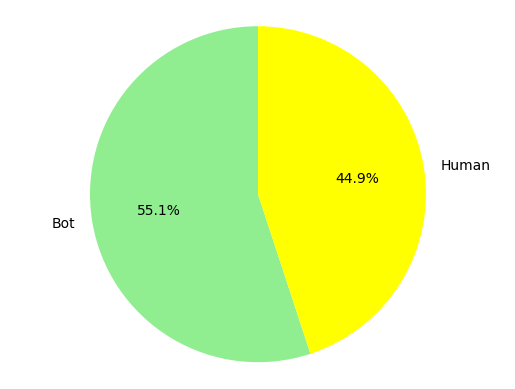

In [6]:
columns_to_drop = ["user_id", "name", "created_at", "day_with_most_tweets"]
df.drop(columns=columns_to_drop, inplace=True)
label = df.pop("bot")

# Visualizing dataset bias
print(label.value_counts())
labels= ['Bot', 'Human']
colors=['lightgreen', 'yellow']
sizes= label.value_counts()
plt.pie(sizes,labels=labels, colors=colors, startangle=90, autopct='%1.1f%%')
plt.axis('equal')
plt.show()

As you can see from the above pie chart, we have a slight bias in favor of the bots-label in our dataset. This might lead to some overtraining down the line.

Lets take a look at our values.

In [7]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
statuses_count,11109.0,486.128364,1.240441e+03,0.000000e+00,4.100000e+01,6.800000e+01,81.000000,7.226000e+03
account_age_in_days,11109.0,1827.599874,5.550895e+02,8.910000e+02,1.312000e+03,1.702000e+03,2080.000000,3.901000e+03
number_of_tweets,11109.0,941.636241,1.199367e+03,1.000000e+00,6.700000e+01,1.320000e+02,1703.000000,3.668000e+03
account_average_tweets_per_day,11109.0,0.262958,6.808833e-01,0.000000e+00,2.247191e-02,3.508772e-02,0.058267,6.792821e+00
avg_tweets_per_actual_day,11109.0,13.376648,3.797705e+01,1.000000e+00,1.846154e+00,4.777778e+00,8.058511,1.759500e+03
max_number_of_tweets_in_a_day,11109.0,52.172383,8.794356e+01,1.000000e+00,6.000000e+00,1.800000e+01,75.000000,2.131000e+03
entropy_for_day,11109.0,2.795355,1.460038e+00,0.000000e+00,1.426345e+00,2.921107e+00,3.710199,5.706424e+00
entropy_for_hour,11109.0,1.995941,1.086827e+00,0.000000e+00,1.032784e+00,2.234517e+00,2.789275,5.705947e+00
entropy_for_minute,11109.0,1.017305,6.785934e-01,0.000000e+00,4.854608e-01,7.215676e-01,1.856961,4.017732e+00
avg_hashtags,11109.0,0.156578,2.333411e-01,0.000000e+00,5.000000e-02,8.571429e-02,0.173913,6.441050e+00


Seeing as some of our values differ by many orders of magnitude, we must standardize our data. Initially we will choose the standardscaler for this job, and only scaling non-categorical data. We will try to use robustscaler later to see if this improves our prediction accuracy, as this scaling method removes some noise. If Robustscaler improves prediction accuracy, then it means that our model might benefit from further noise reduction than what we have done so far in our project.

In [8]:
categoric_col_names = df.columns.values.tolist()
del categoric_col_names[:-1]
numeric_col_names = df.columns.values.tolist()
del numeric_col_names[-1]

In [9]:
df2 = df

In [10]:
standard_scaler = StandardScaler().fit(df[numeric_col_names])

df[numeric_col_names] = standard_scaler.transform(df[numeric_col_names])

In [11]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
statuses_count,11109.0,-1.343181e-17,1.000045,-0.391917,-0.358863,-0.337096,-0.326615,5.433691
account_age_in_days,11109.0,-9.434247e-17,1.000045,-1.687371,-0.928901,-0.226280,0.454722,3.735422
number_of_tweets,11109.0,-2.750323e-17,1.000045,-0.784313,-0.729281,-0.675083,0.634833,2.273271
account_average_tweets_per_day,11109.0,6.396100e-18,1.000045,-0.386219,-0.353213,-0.334684,-0.300639,9.590714
avg_tweets_per_actual_day,11109.0,6.875807e-18,1.000045,-0.325913,-0.303631,-0.226433,-0.140042,45.980453
max_number_of_tweets_in_a_day,11109.0,-7.675320e-18,1.000045,-0.581904,-0.525047,-0.388589,0.259583,23.639265
entropy_for_day,11109.0,8.826618e-17,1.000045,-1.914663,-0.937696,0.086134,0.626618,1.993922
entropy_for_hour,11109.0,-1.624609e-16,1.000045,-1.836567,-0.886250,0.219526,0.729987,3.413765
entropy_for_minute,11109.0,-7.291554e-17,1.000045,-1.499206,-0.783781,-0.435830,1.237403,4.421738
avg_hashtags,11109.0,-2.686362e-17,1.000045,-0.671058,-0.456769,-0.303706,0.074293,26.933767


c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


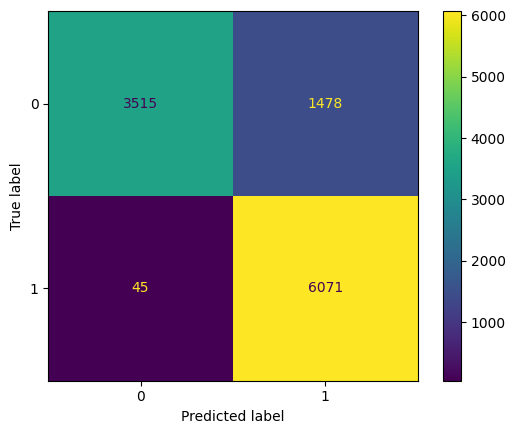

Mean Accuracy on test data = 0.8629039517508327


In [12]:
clf = DecisionTreeClassifier(max_depth=10)
X = df
y = label
clf = clf.fit(X, y)

metrics.plot_confusion_matrix(clf, X, y)
plt.show()
print(f"Mean Accuracy on test data = {clf.score(X, y)}")

Comparing this with robustscaler.

c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


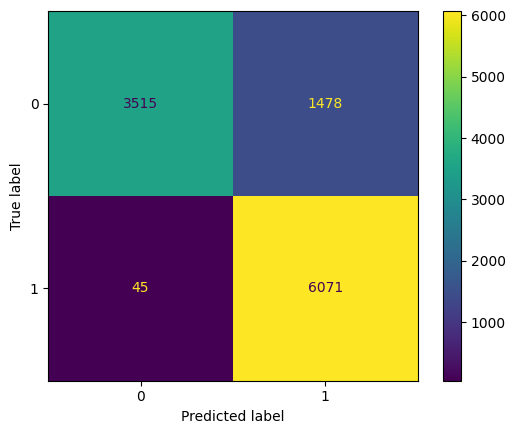

Mean Accuracy on test data = 0.8629039517508327


In [13]:
robust_scaler = RobustScaler().fit(df2[numeric_col_names])

df2[numeric_col_names] = robust_scaler.transform(df2[numeric_col_names])

clf_robust = DecisionTreeClassifier(max_depth=10)
X2 = df2
y = label
clf_robust = clf_robust.fit(X2, y)

metrics.plot_confusion_matrix(clf_robust, X2, y)
plt.show()
print(f"Mean Accuracy on test data = {clf_robust.score(X2, y)}")

As we can see from the results from Standard and Robust scaling on a decision tree with a depth of 10, there is no increase in accuracy. We will compare these scalars for any depth of tree, but for now it seems that we do not have any large amounts of noise in our dataset that would skew our prediction accuracy. Unless the scalar comparisons show a great increase in accuracy while using RobustScalar, we will continue using the StandardScaler, as better to compare our results with the other classification methods. 

### Defining Maximum tree depth and comparing Scaler performances

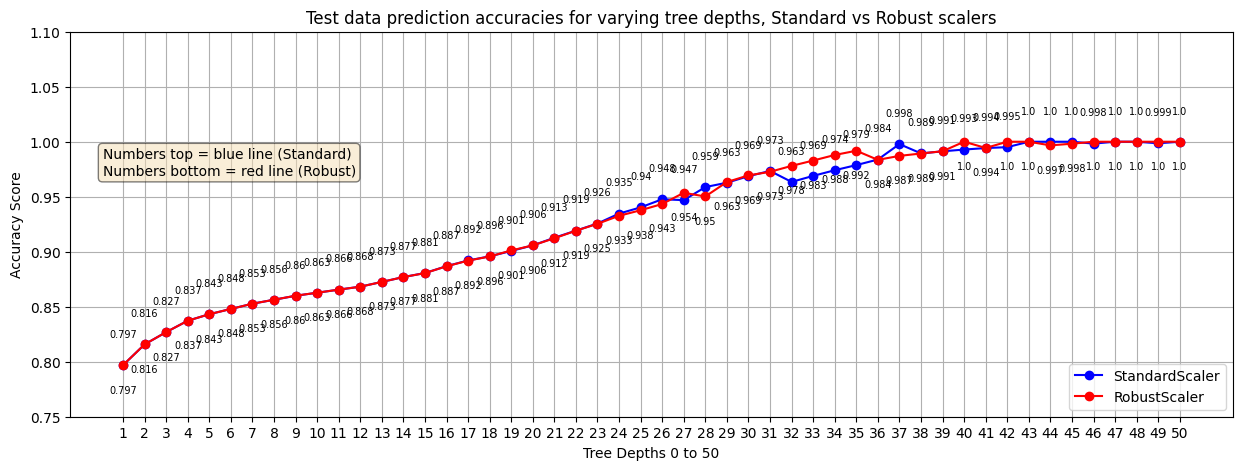

In [14]:
depth_list = [*range(1,50+1,1)]
standard_accuracy_list = []
robust_accuracy_list = []

# Standard scalar
for depths in depth_list:
    clf = DecisionTreeClassifier(max_depth=depths)
    X = df
    y = label
    clf = clf.fit(X, y)

    standard_accuracy_list.append(clf.score(X, y))
# Robust scalar
for depths in depth_list:
    clf_robust = DecisionTreeClassifier(max_depth=depths)
    X = df2
    y = label
    clf_robust = clf_robust.fit(X2, y)

    robust_accuracy_list.append(clf_robust.score(X, y))

# plot this for robust scaler as well - Tengel
fig = plt.figure(figsize = (15, 5))
plt.plot(depth_list, standard_accuracy_list,"-bo")
plt.plot(depth_list, robust_accuracy_list,"-ro")
plt.ylim(0.75, 1.1)
plt.xticks(depth_list)
plt.xlabel(f"Tree Depths 0 to {len(depth_list)}")
plt.ylabel("Accuracy Score")
plt.title("Test data prediction accuracies for varying tree depths, Standard vs Robust scalers")
plt.grid(True)
# Annotating blue line standard scalar accuracies
for xitem,yitem in zip(depth_list,standard_accuracy_list):
    plt.annotate(round(yitem,3), (xitem,yitem), textcoords="offset points",xytext=(0,20),ha="center", fontsize=7)
# Annotating red line robust scalar accuracies
for xitem,yitem in zip(depth_list,robust_accuracy_list):
    plt.annotate(round(yitem,3), (xitem,yitem), textcoords="offset points",xytext=(0,-20),ha="center", fontsize=7)
plt.legend(["StandardScaler", "RobustScaler"], loc ="lower right")
# Creating textbox
textstr = "Numbers top = blue line (Standard)\nNumbers bottom = red line (Robust)"
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.05, 0.97, textstr, bbox=props)
plt.show()

We can see from the above graph that the accuracy peaks at a tree depth of 40. But we have great prediction scores already at a depth of 35 for both Scaler methods.

We can see from the comparison chart above that the scalars perform equally on tree depths below 20, with some difference in performance on tree depths above 20. Since the scalar methods perform so equally we will continue using the Standardscalar, in order to compare our results with the other classifiers in this project more easily.

### Gini VS Entropy

We will now compare if the algorithm performs better using gini or entropy for feature selection.

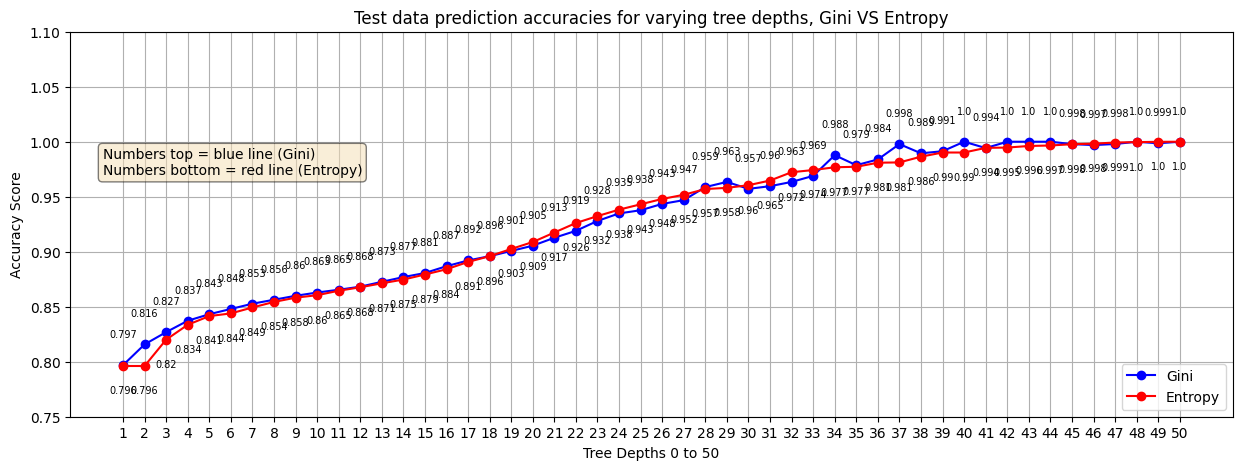

In [15]:
depth_list = [*range(1,50+1,1)]
gini_accuracy_list = []
entropy_accuracy_list = []
# Gini Coefficient
for depths in depth_list:
    clf = DecisionTreeClassifier(max_depth=depths, criterion="gini")
    X = df
    y = label
    clf = clf.fit(X, y)

    gini_accuracy_list.append(clf.score(X, y))
# Entropy Coefficient
for depths in depth_list:
    clf = DecisionTreeClassifier(max_depth=depths, criterion="entropy")
    X = df
    y = label
    clf = clf.fit(X, y)

    entropy_accuracy_list.append(clf.score(X, y))

# plot this for robust scaler as well - Tengel
fig = plt.figure(figsize = (15, 5))
plt.plot(depth_list, gini_accuracy_list,"-bo")
plt.plot(depth_list, entropy_accuracy_list,"-ro")
plt.ylim(0.75, 1.1)
plt.xticks(depth_list)
plt.xlabel(f"Tree Depths 0 to {len(depth_list)}")
plt.ylabel("Accuracy Score")
plt.title("Test data prediction accuracies for varying tree depths, Gini VS Entropy")
plt.grid(True)
# Annotating blue line Gini accuracies
for xitem,yitem in zip(depth_list,gini_accuracy_list):
    plt.annotate(round(yitem,3), (xitem,yitem), textcoords="offset points",xytext=(0,20),ha="center", fontsize=7)
# Annotating red line Entropy accuracies
for xitem,yitem in zip(depth_list,entropy_accuracy_list):
    plt.annotate(round(yitem,3), (xitem,yitem), textcoords="offset points",xytext=(0,-20),ha="center", fontsize=7)
plt.legend(["Gini", "Entropy"], loc ="lower right")
# Creating textbox
textstr = "Numbers top = blue line (Gini)\nNumbers bottom = red line (Entropy)"
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.05, 0.97, textstr, bbox=props)
plt.show()

From the graph above we can see that using the Gini coefficient performs better at most tree depths in our range. Comparing this figure with the figure comparing scalers, we can see that prediction accuracies peaks at 37 for both figures.
As a prediction accuracy of 99% is enough for our usecase and it will save us test/computing time, we will set our maximum tree depth to 37 for this reason.

### Feature Selection / Dimensionality reduction

Now that our data is standardized, we can take a look at what features provide the most information to our desicionmaking process. In addition we will explore what features are dropped at lower tree depths

In [16]:
max_depth = 37
useless_features = plot_feature_importance(df, label, max_tree_depth=max_depth, criterion="gini")

The following features were dropped:
[]


In [17]:
useless_features = plot_feature_importance(df, label, max_tree_depth=10, criterion="gini")

The following features were dropped:
[]


In [18]:
useless_features = plot_feature_importance(df, label, max_tree_depth=5, criterion="gini")

The following features were dropped:
['total_replies', 'total_likes', 'account_discussion_creation_ratio', 'entropy_for_minute', 'entropy_for_day', 'max_number_of_tweets_in_a_day', 'avg_tweets_per_actual_day', 'mean_inactive_period_length_in_seconds', 'median_inactive_period_length_in_seconds', 'mode_count', 'statuses_count']


With a shallower desicion tree, we can see that more features will be dropped by the algorithm according to the features with the highest Gini coefficient. A shallower tree is easier to interpret.

### Defining tree width
The wider the tree, the harder it is to interpret and the longer it takes to compute. Finding the optimal tree width can sometimes be of importance when wanting to increase interpretability or decrease computational cost. Since our dataset is so small, we will not be researching this any further. But if we were, we would take a look at the parameters:
* min_samples_split
* min_samples_leaf
* max_leaf_nodes, 
All from the scikit-learn decision tree classifier module.

## Applying the Decision tree classification method and the K-fold cross validation

Finding the best tree depth for balance between model complexity and overtraining.

In [19]:
depth_list = [*range(1,37+1,1)]
complete_metrics_df = pd.DataFrame(
    [
        [None, None, None, None, None, None]
        for depths in depth_list
    ],
    index= [depths for depths in depth_list],
    columns=["Mean Training Accuracy", "Mean Validation Accuracy", "Mean Training Precision", "Mean Validation Precision", "Mean Training F1 Score", "Mean Validation F1 Score"]
)

for depths in depth_list:
    # K-fold and classify
    results = fold_classify_results(df, label, cv= 10, max_tree_depth= depths, criterion= "gini")
    # get metrics
    complete_metrics_df.loc[depths]["Mean Training Accuracy"] = results["Mean Training Accuracy"]
    complete_metrics_df.loc[depths]["Mean Validation Accuracy"] = results["Mean Validation Accuracy"]
    complete_metrics_df.loc[depths]["Mean Training Precision"] = results["Mean Training Precision"]
    complete_metrics_df.loc[depths]["Mean Validation Precision"] = results["Mean Validation Precision"]
    complete_metrics_df.loc[depths]["Mean Training F1 Score"] = results["Mean Training F1 Score"]
    complete_metrics_df.loc[depths]["Mean Validation F1 Score"] = results["Mean Validation F1 Score"]

complete_metrics_df.index.names = ['Max Tree Depth']
complete_metrics_df


,Mean Training Accuracy,Mean Validation Accuracy,Mean Training Precision,Mean Validation Precision,Mean Training F1 Score,Mean Validation F1 Score
Max Tree Depth,,,,,,
1,79.700144,79.557212,0.742778,0.741744,0.839694,0.838625
2,81.23044,80.376238,0.772097,0.767016,0.845886,0.838496
3,82.910749,82.212681,0.777243,0.772844,0.861666,0.855944
4,83.820925,82.97783,0.784751,0.778124,0.868809,0.862157
5,84.427041,83.473009,0.788292,0.781651,0.873937,0.866203
6,84.863124,83.553977,0.793299,0.783909,0.877047,0.866418
7,85.31621,83.72501,0.796119,0.785105,0.880835,0.867853
8,85.722287,83.769958,0.800034,0.785501,0.883932,0.868203
9,86.053351,83.868992,0.802505,0.786204,0.886615,0.869019


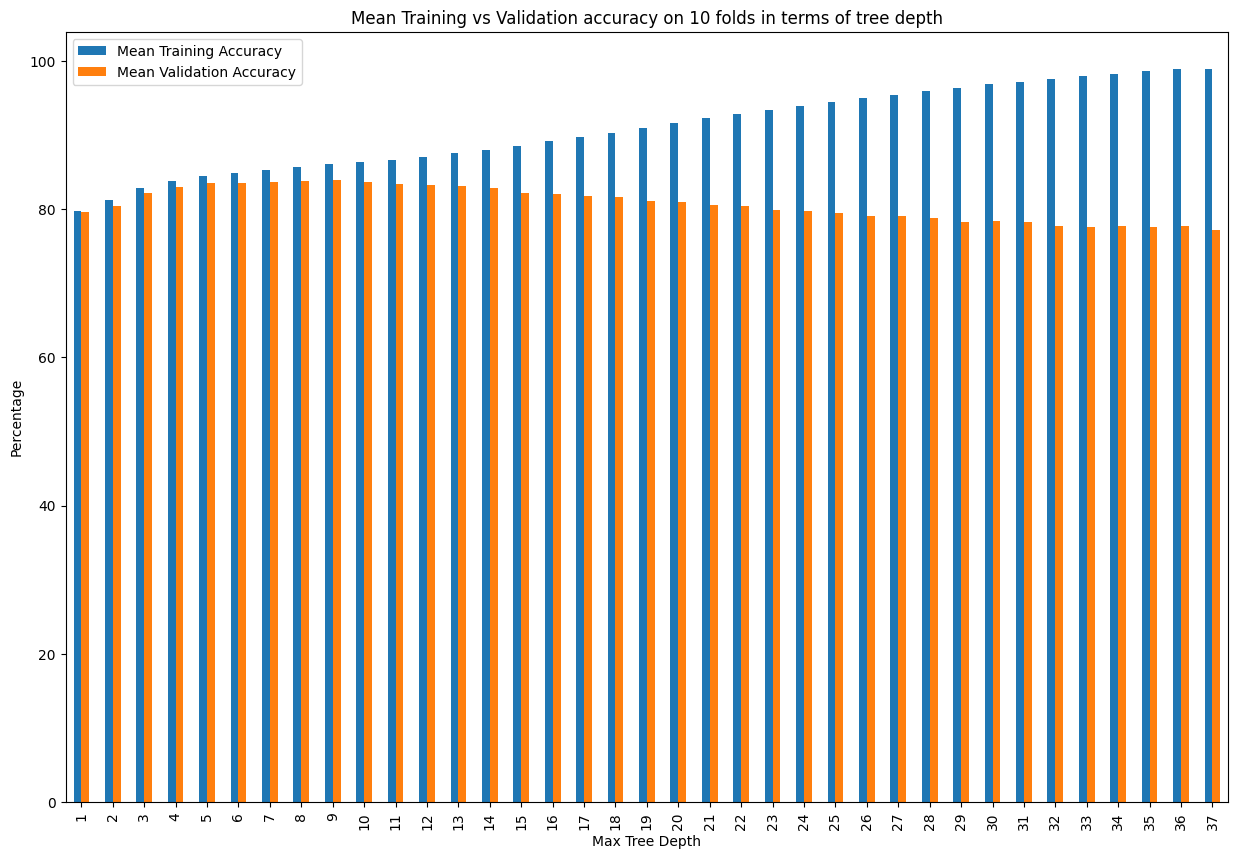

In [20]:
select_metrics_df = complete_metrics_df.iloc[:, [0,1]]
select_metrics_df.plot(kind= "bar", figsize=(15, 10), ylabel="Percentage", title="Mean Training vs Validation accuracy on 10 folds in terms of tree depth")#, subplots=True)
plt.show()

By comparing the table and the figure above, we can see that our best performing and balanced Decision tree model is found at a maximum tree depth of 9. This depth also has the greatest F1 score. Below a tree depth of 9, we find a balanced model but with a negative trend in terms of prediction performance and F1 scores.

In order to find the best performing decision tree with a high degree of interpretability, We compare the Decision trees with comparable performance below the depth of 9.

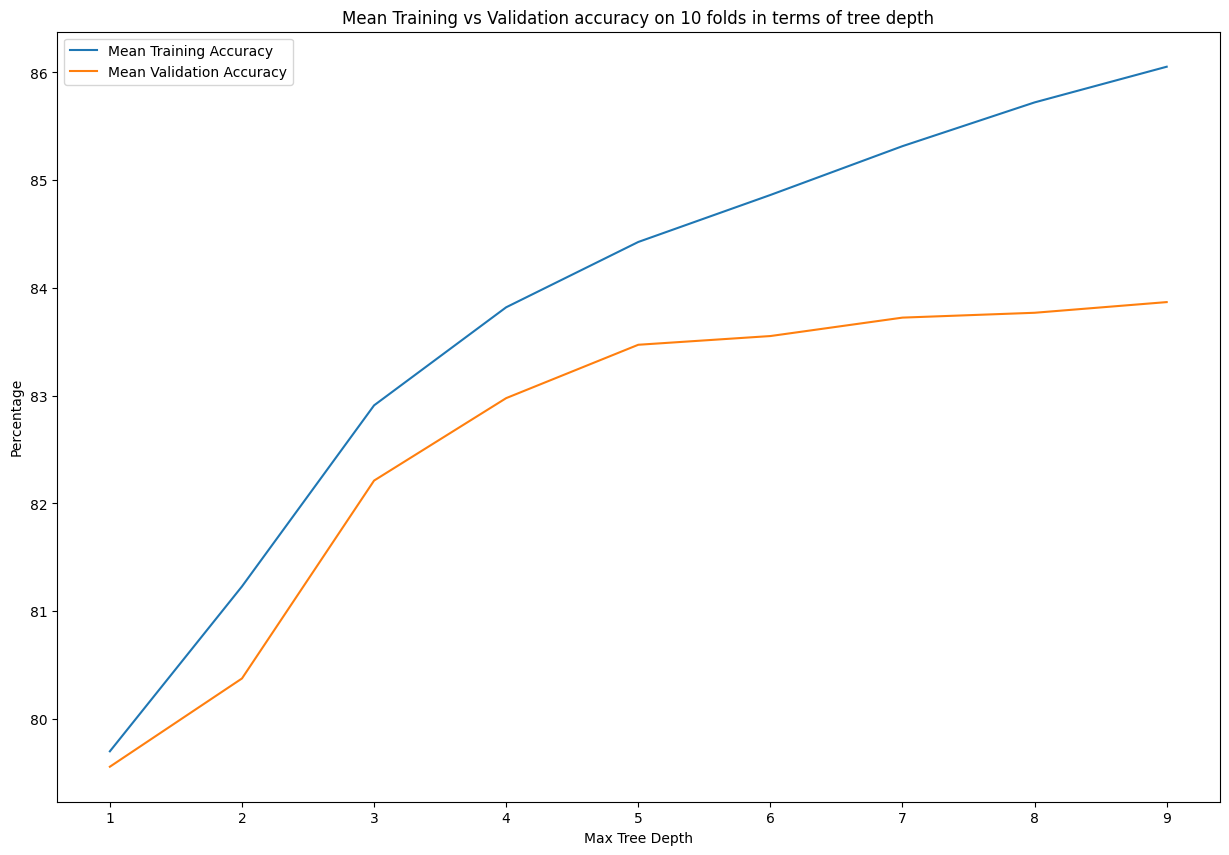

In [21]:
select_metrics_df = complete_metrics_df.iloc[0:9, [0,1]]
select_metrics_df.plot(kind= "line", figsize=(15, 10), ylabel="Percentage", title="Mean Training vs Validation accuracy on 10 folds in terms of tree depth")#, subplots=True)
plt.show()

We can see from the above graph that there seems to be two points of divergence betweet the training and validation accuracies. These are found at depths 3 and 5. One may argue that there might be a tradeoff between a depth of 3, 5 and 9 between performance and interpretability. Visualizing each tree at 3, 5 and 9 for interpretability comparisons.

In [22]:
complete_metrics_df.iloc[[2,4,8], [0,1,-2,-1]]

,Mean Training Accuracy,Mean Validation Accuracy,Mean Training F1 Score,Mean Validation F1 Score
Max Tree Depth,,,,
3,82.910749,82.212681,0.861666,0.855944
5,84.427041,83.473009,0.873937,0.866203
9,86.053351,83.868992,0.886615,0.869019


In [23]:
tree_depths_list = [9, 5, 3]
for depths in tree_depths_list:
    # K-fold and plot
    fold_classify_and_plot2(df, label, cv= 10, max_tree_depth= depths, criterion= "gini")


{'Training Accuracy scores': array([0.86067213, 0.85867173, 0.85967193, 0.86117223, 0.85697139,
       0.86327265, 0.86227245, 0.86147229, 0.86087217, 0.86008601]), 'Mean Training Accuracy': 86.0513501840282, 'Training Precision scores': array([0.80375351, 0.79979481, 0.80096874, 0.80229142, 0.79824305,
       0.8036999 , 0.80487445, 0.80410393, 0.80419994, 0.80262382]), 'Mean Training Precision': 0.8024553556520155, 'Training Recall scores': array([0.98819041, 0.99146076, 0.99146076, 0.99236919, 0.99055233,
       0.99454942, 0.98982743, 0.98946412, 0.98782925, 0.98910082]), 'Mean Training Recall': 0.9904804465549288, 'Training F1 scores': array([0.88648032, 0.88537357, 0.88609239, 0.88726446, 0.88406032,
       0.88899716, 0.88782077, 0.8872058 , 0.88660634, 0.88615835]), 'Mean Training F1 Score': 0.8866059486399396, 'Validation Accuracy scores': array([0.83438344, 0.83618362, 0.85058506, 0.83708371, 0.8469847 ,
       0.81638164, 0.83438344, 0.84158416, 0.84338434, 0.84594595]), 'Me

c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names



{'Training Accuracy scores': array([0.84426885, 0.84186837, 0.84286857, 0.84346869, 0.84216843,
       0.84606921, 0.84706941, 0.84416883, 0.84606921, 0.84468447]), 'Mean Training Accuracy': 84.4270407236763, 'Training Precision scores': array([0.78856558, 0.78497748, 0.78678722, 0.78950463, 0.78457524,
       0.79090242, 0.79141014, 0.78755646, 0.79059203, 0.78804665]), 'Mean Training Precision': 0.7882917857094177, 'Training Recall scores': array([0.97983285, 0.98164971, 0.98019622, 0.97583576, 0.98328488,
       0.97928779, 0.98074478, 0.9818347 , 0.98001817, 0.98201635]), 'Mean Training Recall': 0.9804701196586614, 'Training F1 scores': array([0.87385563, 0.87236619, 0.87290672, 0.8728366 , 0.87276246,
       0.87507103, 0.87596333, 0.87402975, 0.87517236, 0.87440356]), 'Mean Training F1 Score': 0.8739367626021206, 'Validation Accuracy scores': array([0.8289829 , 0.83078308, 0.84518452, 0.83258326, 0.84068407,
       0.80828083, 0.83618362, 0.83528353, 0.8379838 , 0.85135135]), 'Me

c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names



{'Training Accuracy scores': array([0.82826565, 0.82926585, 0.82596519, 0.82706541, 0.82256451,
       0.82936587, 0.83376675, 0.82956591, 0.83226645, 0.8329833 ]), 'Mean Training Accuracy': 82.91074916653498, 'Training Precision scores': array([0.77509807, 0.77646716, 0.77267459, 0.77256318, 0.77386197,
       0.77529719, 0.78487769, 0.77483731, 0.78414489, 0.7826087 ]), 'Mean Training Precision': 0.7772430734882715, 'Training Recall scores': array([0.96929506, 0.96875   , 0.96893169, 0.97202035, 0.95748547,
       0.97165698, 0.96167121, 0.973297  , 0.95949137, 0.96457766]), 'Mean Training Recall': 0.9667176773757472, 'Training F1 scores': array([0.86138694, 0.86201601, 0.85974528, 0.86088985, 0.85593633,
       0.86244154, 0.86432653, 0.86280193, 0.86300139, 0.86411717]), 'Mean Training F1 Score': 0.8616662976505542, 'Validation Accuracy scores': array([0.82358236, 0.81818182, 0.83348335, 0.81818182, 0.82538254,
       0.79207921, 0.82628263, 0.82358236, 0.83168317, 0.82882883]), 'M

c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names



Comparing the visualization done by the Dtreeviz module, you might say that there is a world of difference between the best performing tree depth of 9 and the more comparative 5 and 3. The easiest tree to interpret is 3 of course, but the tree with a depth of 5 is not too challenging either. 

### Putting it all together

{'Training Accuracy scores': array([0.98339668, 0.99819964, 0.98219644, 0.99469894, 0.97139428,
       0.9989998 , 0.99559912, 0.99309862, 0.99929986, 0.99369937]), 'Mean Training Accuracy': 99.10582746612329, 'Training Precision scores': array([0.97289157, 0.99746101, 0.96949929, 0.99187872, 0.95373913,
       0.99872912, 0.99260328, 0.98920086, 0.99873004, 0.99151012]), 'Mean Training Precision': 0.9856243149853785, 'Training Recall scores': array([0.99763808, 0.99927326, 0.99909157, 0.99854651, 0.99636628,
       0.99945494, 0.99945504, 0.99836512, 1.        , 0.99709355]), 'Mean Training Recall': 0.9985284354339606, 'Training F1 scores': array([0.98510944, 0.99836631, 0.98407301, 0.99520145, 0.97458681,
       0.9990919 , 0.99601738, 0.99376187, 0.99936462, 0.994294  ]), 'Mean Training F1 Score': 0.9919866780041412, 'Validation Accuracy scores': array([0.77317732, 0.78037804, 0.78577858, 0.77047705, 0.77587759,
       0.78037804, 0.77227723, 0.7749775 , 0.76867687, 0.76666667]), 'M

The following features were dropped:
[]


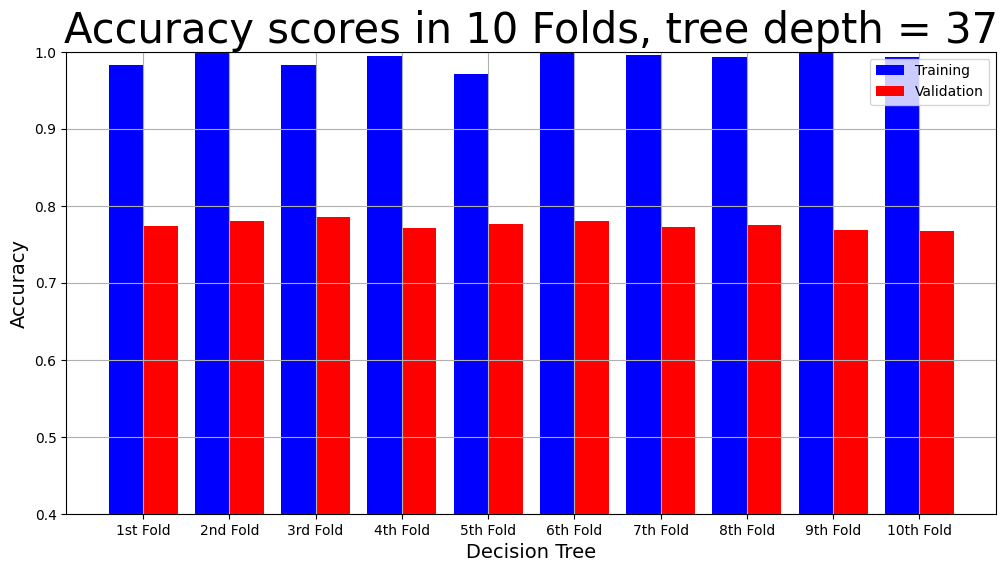

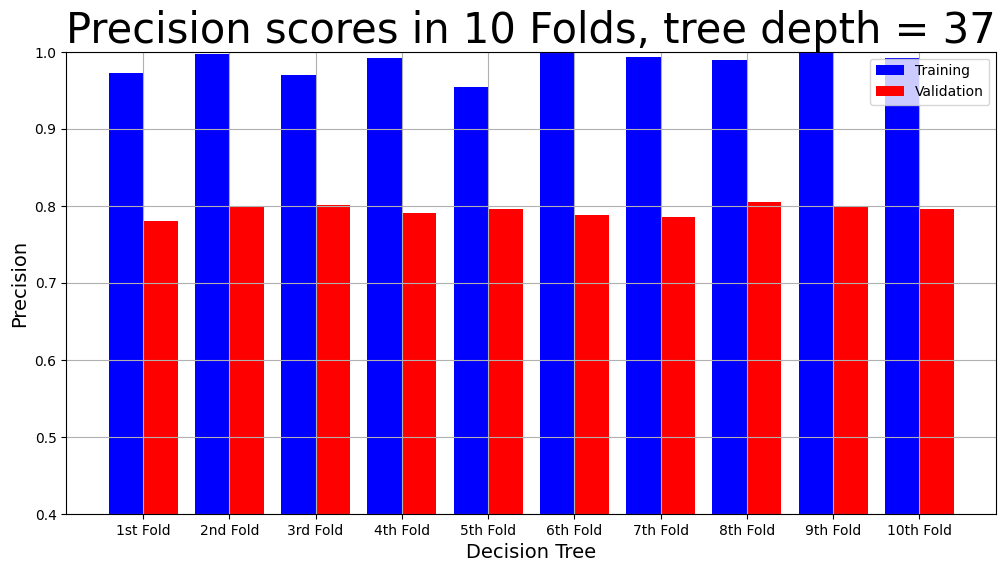

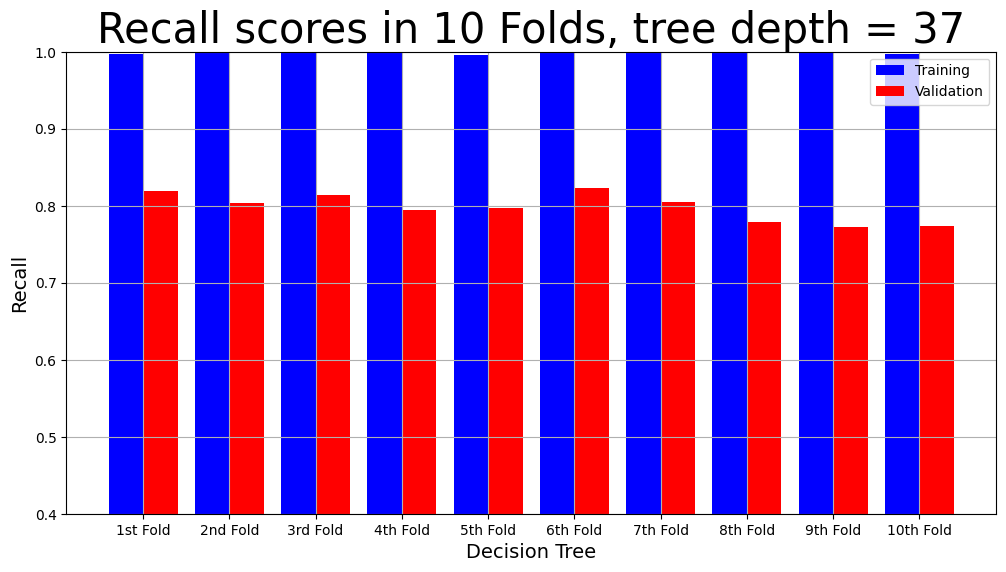

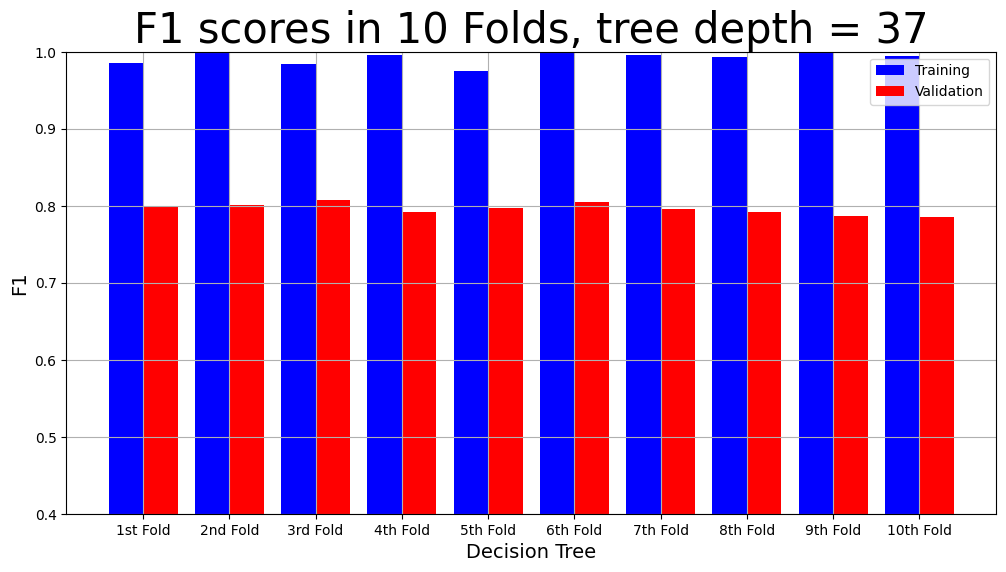

c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



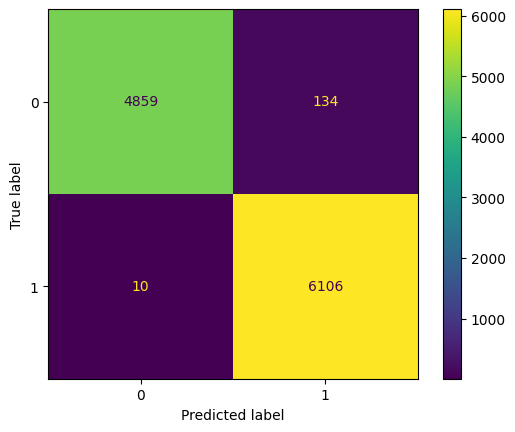

c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names



{'Training Accuracy scores': array([0.86077215, 0.85847169, 0.85977195, 0.86117223, 0.85687137,
       0.86327265, 0.86227245, 0.86147229, 0.86087217, 0.86008601]), 'Mean Training Accuracy': 86.0503499839882, 'Training Precision scores': array([0.80369276, 0.79964825, 0.80117474, 0.80229142, 0.7982135 ,
       0.8036999 , 0.80487445, 0.80410393, 0.80419994, 0.80262382]), 'Mean Training Precision': 0.802452270857365, 'Training Recall scores': array([0.98855378, 0.99127907, 0.99127907, 0.99236919, 0.99037064,
       0.99454942, 0.98982743, 0.98946412, 0.98782925, 0.98910082]), 'Mean Training Recall': 0.9904622779502776, 'Training F1 scores': array([0.88658954, 0.88521132, 0.88614585, 0.88726446, 0.88396984,
       0.88899716, 0.88782077, 0.8872058 , 0.88660634, 0.88615835]), 'Mean Training F1 Score': 0.8865969433914824, 'Validation Accuracy scores': array([0.83168317, 0.83708371, 0.85058506, 0.84068407, 0.8469847 ,
       0.81728173, 0.83438344, 0.84248425, 0.84428443, 0.84414414]), 'Mea

The following features were dropped:
[]


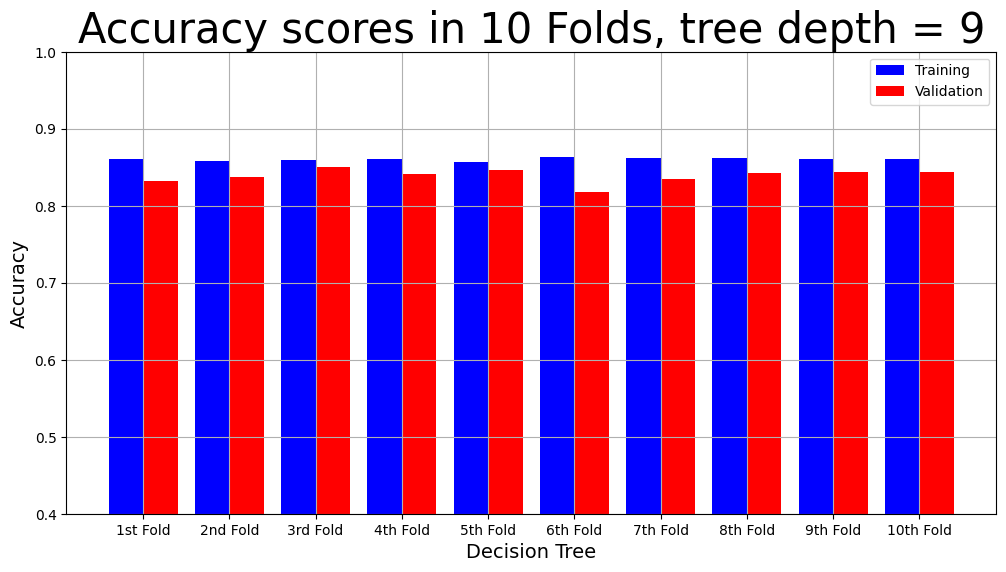

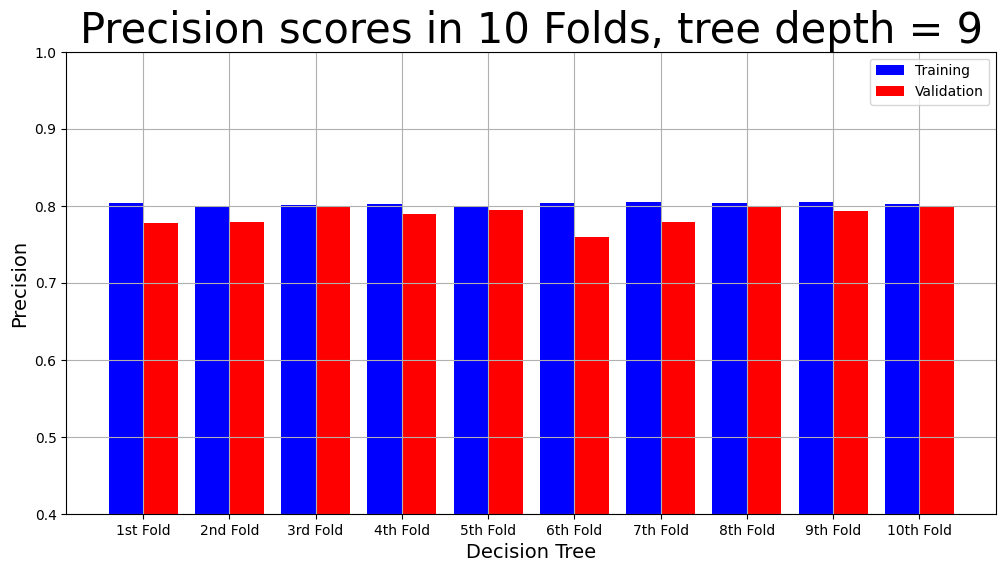

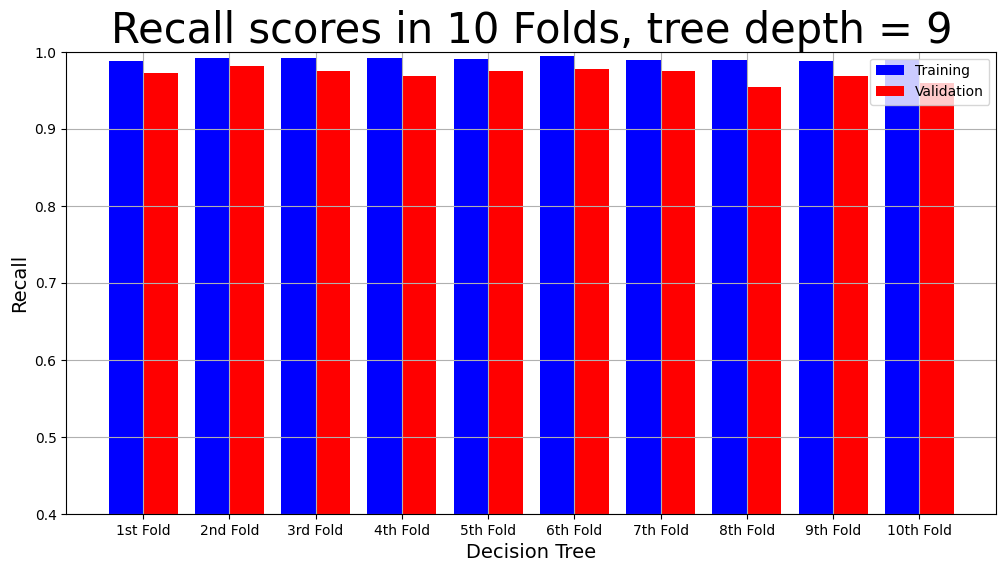

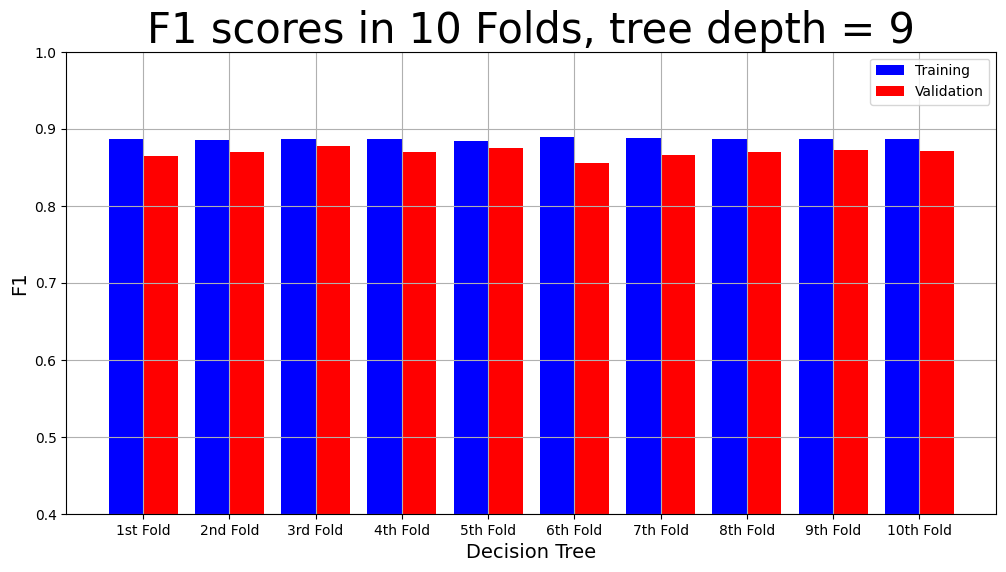

c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



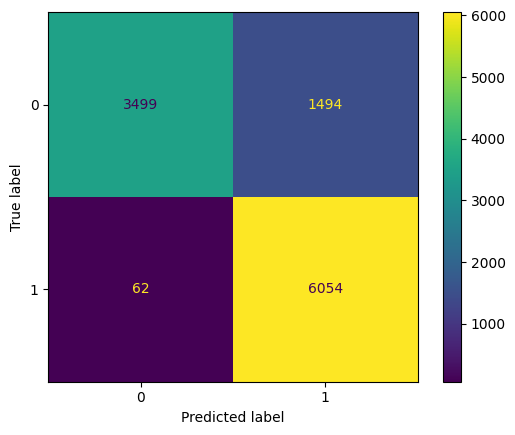

c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names



{'Training Accuracy scores': array([0.84426885, 0.84186837, 0.84286857, 0.84346869, 0.84216843,
       0.84606921, 0.84706941, 0.84416883, 0.84606921, 0.84468447]), 'Mean Training Accuracy': 84.4270407236763, 'Training Precision scores': array([0.78856558, 0.78497748, 0.78678722, 0.78950463, 0.78457524,
       0.79090242, 0.79141014, 0.78755646, 0.79059203, 0.78804665]), 'Mean Training Precision': 0.7882917857094177, 'Training Recall scores': array([0.97983285, 0.98164971, 0.98019622, 0.97583576, 0.98328488,
       0.97928779, 0.98074478, 0.9818347 , 0.98001817, 0.98201635]), 'Mean Training Recall': 0.9804701196586614, 'Training F1 scores': array([0.87385563, 0.87236619, 0.87290672, 0.8728366 , 0.87276246,
       0.87507103, 0.87596333, 0.87402975, 0.87517236, 0.87440356]), 'Mean Training F1 Score': 0.8739367626021206, 'Validation Accuracy scores': array([0.82988299, 0.83078308, 0.84518452, 0.83168317, 0.84068407,
       0.80648065, 0.83618362, 0.83618362, 0.8379838 , 0.85135135]), 'Me

The following features were dropped:
['total_replies', 'total_likes', 'account_discussion_creation_ratio', 'entropy_for_minute', 'entropy_for_day', 'max_number_of_tweets_in_a_day', 'avg_tweets_per_actual_day', 'mean_inactive_period_length_in_seconds', 'mode_inactive_period_length_in_seconds', 'mode_count', 'statuses_count']


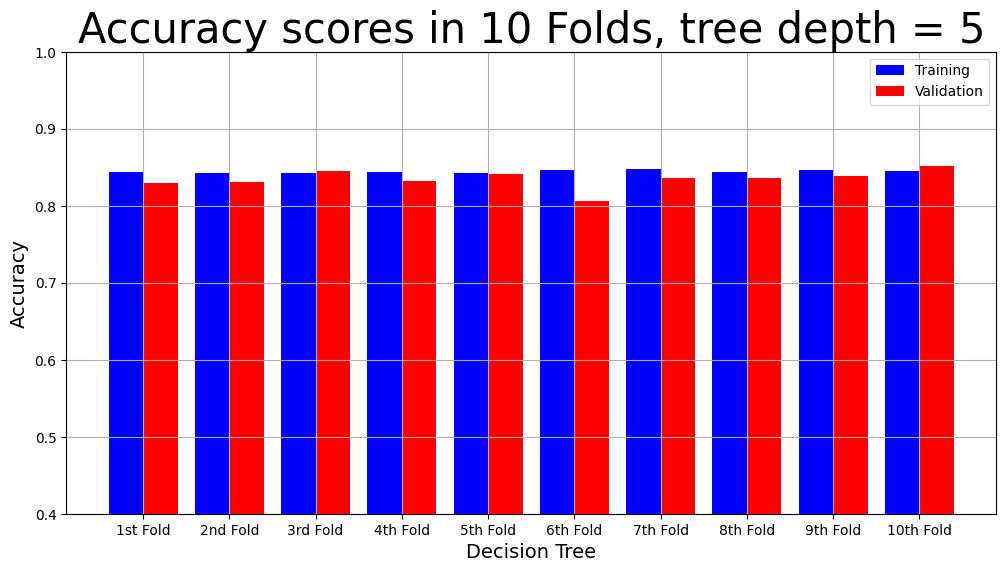

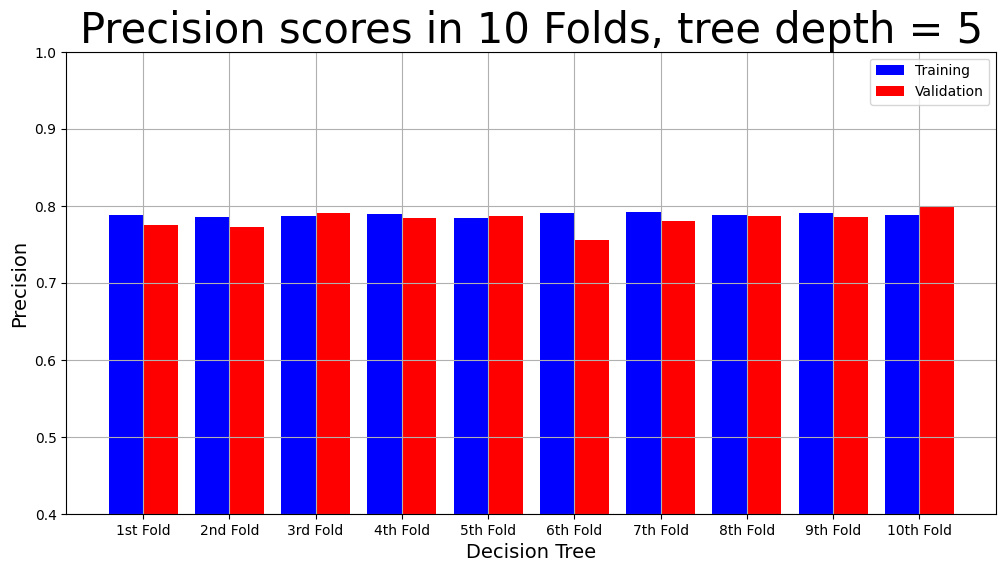

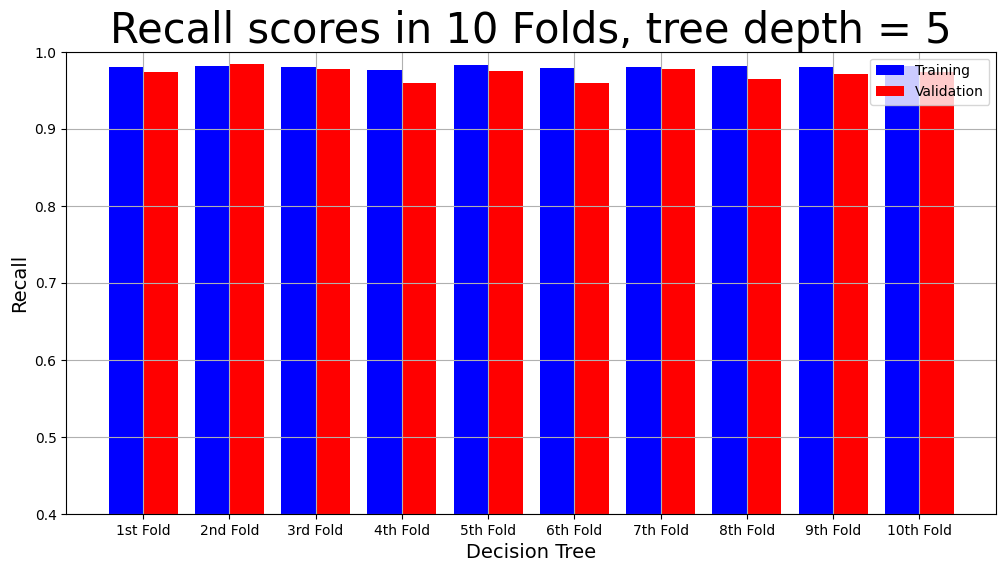

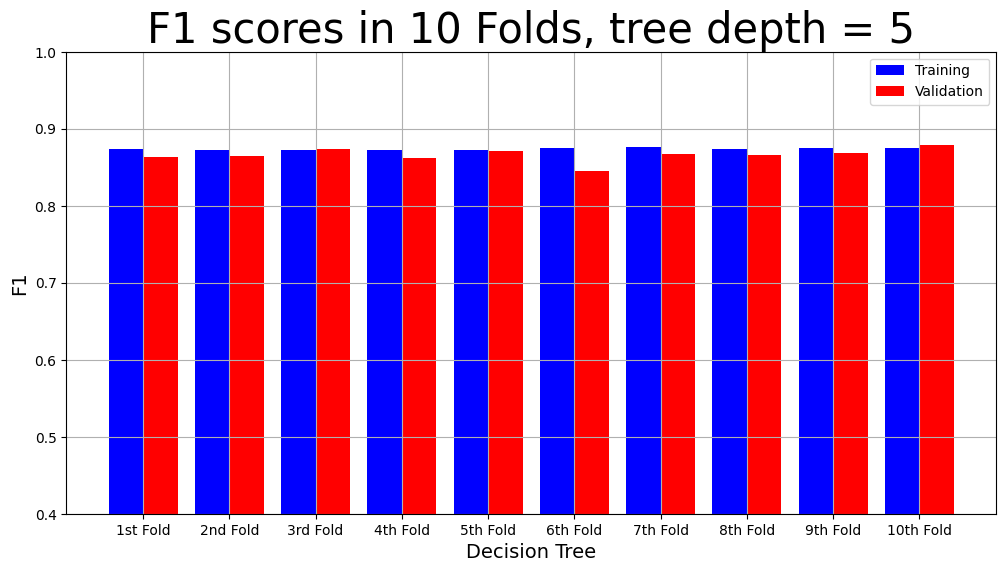

c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



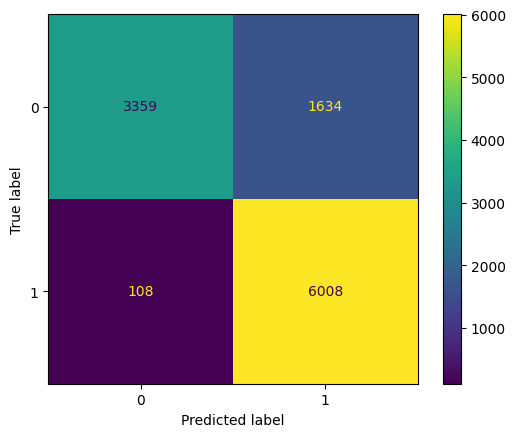

c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names



{'Training Accuracy scores': array([0.82826565, 0.82926585, 0.82596519, 0.82706541, 0.82256451,
       0.82936587, 0.83376675, 0.82956591, 0.83226645, 0.8329833 ]), 'Mean Training Accuracy': 82.91074916653498, 'Training Precision scores': array([0.77509807, 0.77646716, 0.77267459, 0.77256318, 0.77386197,
       0.77529719, 0.78487769, 0.77483731, 0.78414489, 0.7826087 ]), 'Mean Training Precision': 0.7772430734882715, 'Training Recall scores': array([0.96929506, 0.96875   , 0.96893169, 0.97202035, 0.95748547,
       0.97165698, 0.96167121, 0.973297  , 0.95949137, 0.96457766]), 'Mean Training Recall': 0.9667176773757472, 'Training F1 scores': array([0.86138694, 0.86201601, 0.85974528, 0.86088985, 0.85593633,
       0.86244154, 0.86432653, 0.86280193, 0.86300139, 0.86411717]), 'Mean Training F1 Score': 0.8616662976505542, 'Validation Accuracy scores': array([0.82358236, 0.81818182, 0.83348335, 0.81818182, 0.82538254,
       0.79207921, 0.82628263, 0.82358236, 0.83168317, 0.82882883]), 'M

The following features were dropped:
['statuses_count', 'avt_reply_count', 'mode_count', 'mode_inactive_period_length_in_seconds', 'median_inactive_period_length_in_seconds', 'mean_inactive_period_length_in_seconds', 'entropy_original_text', 'tweet_num_replies_ratio', 'account_discussion_creation_ratio', 'avt_favorite_count', 'total_replies', 'account_age_in_days', 'total_likes', 'avg_special_char_in_text', 'avg_text_length', 'avg_hashtags', 'entropy_for_minute', 'entropy_for_day', 'max_number_of_tweets_in_a_day', 'avg_tweets_per_actual_day', 'number_of_tweets', 'lang_num']


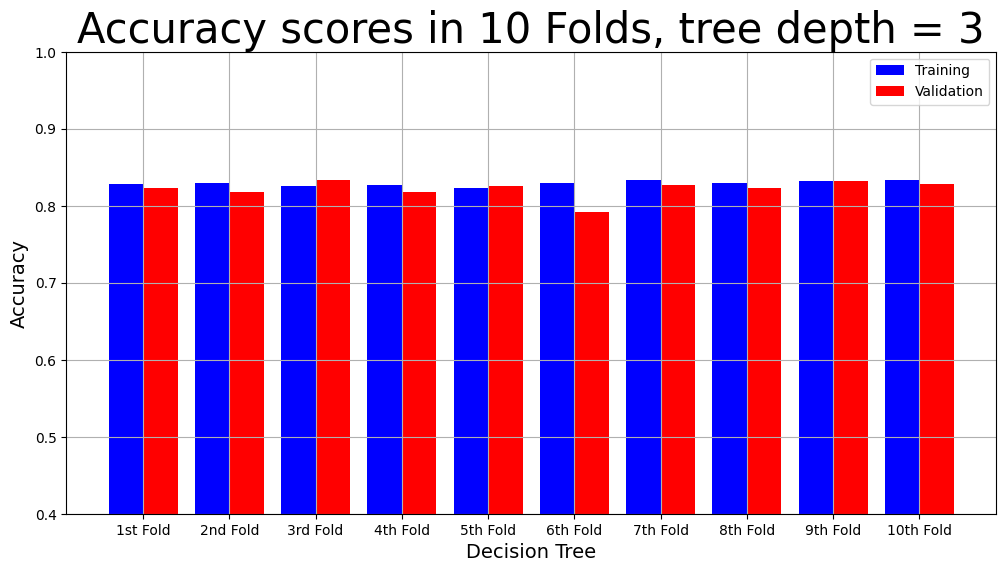

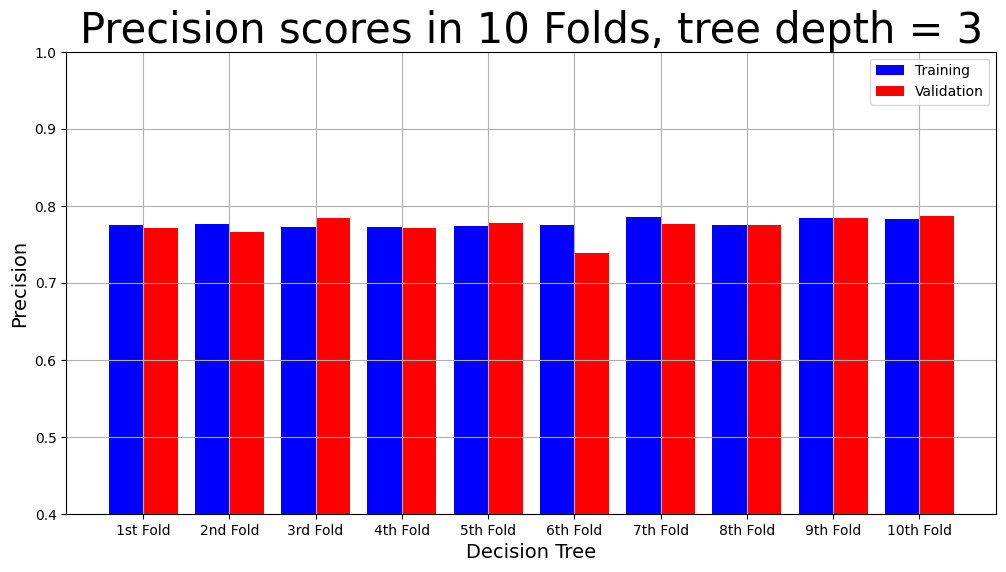

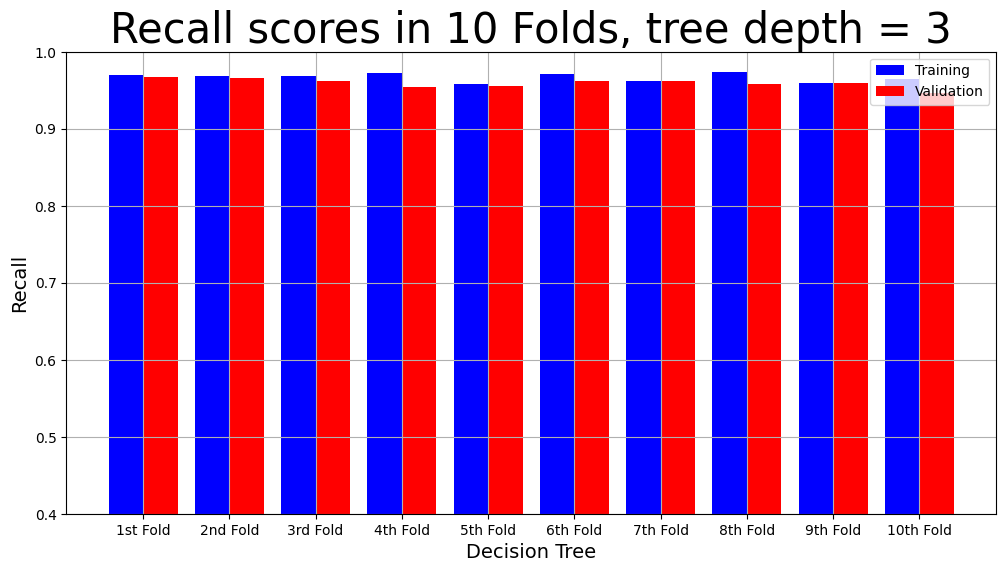

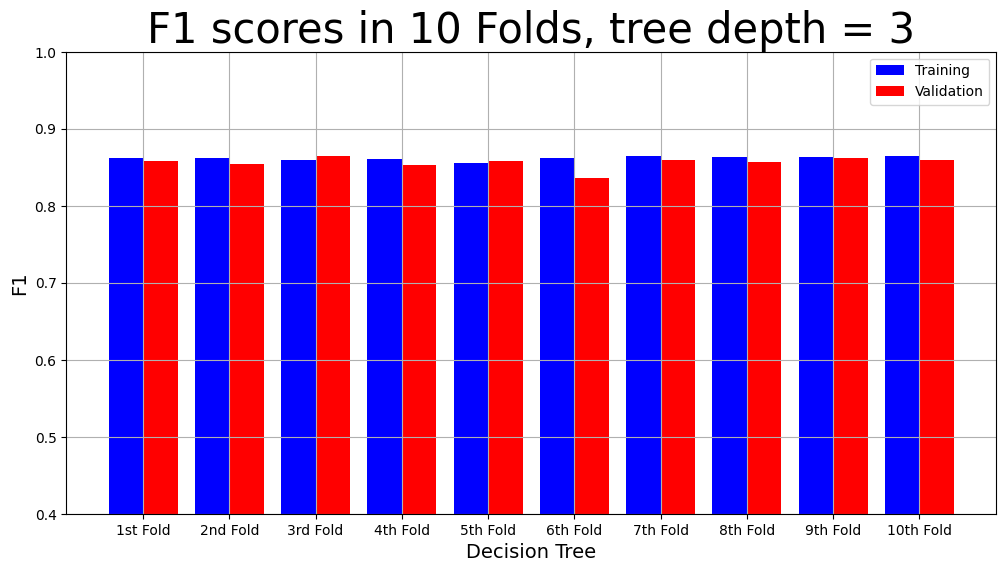

c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



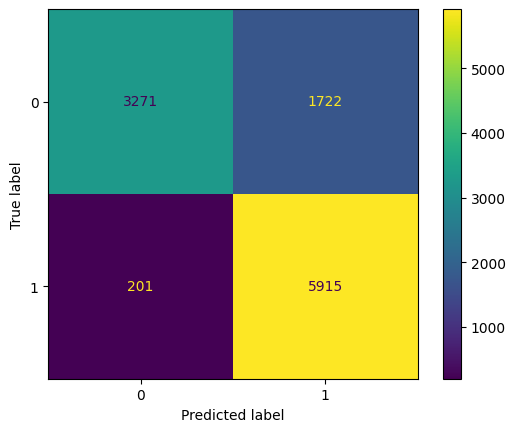

c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names



,Mean Training Accuracy,Mean Validation Accuracy,Mean Training Precision,Mean Validation Precision,Mean Training F1 Score,Mean Validation F1 Score
Max Tree Depth,,,,,,
37,99.113829,77.171544,0.985612,0.790337,0.99206,0.793463
9,86.05035,83.88701,0.802452,0.786259,0.886597,0.869188
5,84.427041,83.500012,0.788292,0.78189,0.873937,0.866414
3,82.910749,82.212681,0.777243,0.772844,0.861666,0.855944


In [24]:
tree_depths_list = [37, 9, 5, 3]
metrics_df = pd.DataFrame(
    [
        [None, None, None, None, None, None]
        for depths in tree_depths_list
    ],
    index= [depths for depths in tree_depths_list],
    columns=["Mean Training Accuracy", "Mean Validation Accuracy", "Mean Training Precision", "Mean Validation Precision", "Mean Training F1 Score", "Mean Validation F1 Score"]
)

for depths in tree_depths_list:
    # K-fold and plot
    fold_classify_and_plot1(df, label, cv= 10, max_tree_depth= depths, criterion= "gini")
    results = fold_classify_results(df, label, cv= 10, max_tree_depth= depths, criterion= "gini")
    # get metrics
    metrics_df.loc[depths]["Mean Training Accuracy"] = results["Mean Training Accuracy"]
    metrics_df.loc[depths]["Mean Validation Accuracy"] = results["Mean Validation Accuracy"]
    metrics_df.loc[depths]["Mean Training Precision"] = results["Mean Training Precision"]
    metrics_df.loc[depths]["Mean Validation Precision"] = results["Mean Validation Precision"]
    metrics_df.loc[depths]["Mean Training F1 Score"] = results["Mean Training F1 Score"]
    metrics_df.loc[depths]["Mean Validation F1 Score"] = results["Mean Validation F1 Score"]

metrics_df.index.names = ['Max Tree Depth']
metrics_df


{'Training Accuracy scores': array([0.9834967 , 0.98109622, 0.98229646, 0.9954991 , 0.97119424,
       0.9989998 , 0.99559912, 0.99319864, 0.99979996, 0.99409941]), 'Mean Training Accuracy': 98.95279645988204, 'Training Precision scores': array([0.97306397, 0.96844703, 0.96950467, 0.99349123, 0.95324991,
       0.99872912, 0.99313708, 0.98885093, 0.99981835, 0.9895721 ]), 'Mean Training Precision': 0.9827864386986086, 'Training Recall scores': array([0.99763808, 0.99818314, 0.99927326, 0.99836483, 0.99654797,
       0.99945494, 0.99891008, 0.99891008, 0.99981835, 0.99981835]), 'Mean Training Recall': 0.9986919066704688, 'Training F1 scores': array([0.98519781, 0.98309027, 0.98416391, 0.99592207, 0.97441819,
       0.9990919 , 0.99601521, 0.99385505, 0.99981835, 0.99466884]), 'Mean Training F1 Score': 0.9906241599551509, 'Validation Accuracy scores': array([0.77137714, 0.78577858, 0.78937894, 0.76417642, 0.78487849,
       0.77227723, 0.78127813, 0.77137714, 0.75877588, 0.77297297]), 'M

The following features were dropped:
[]


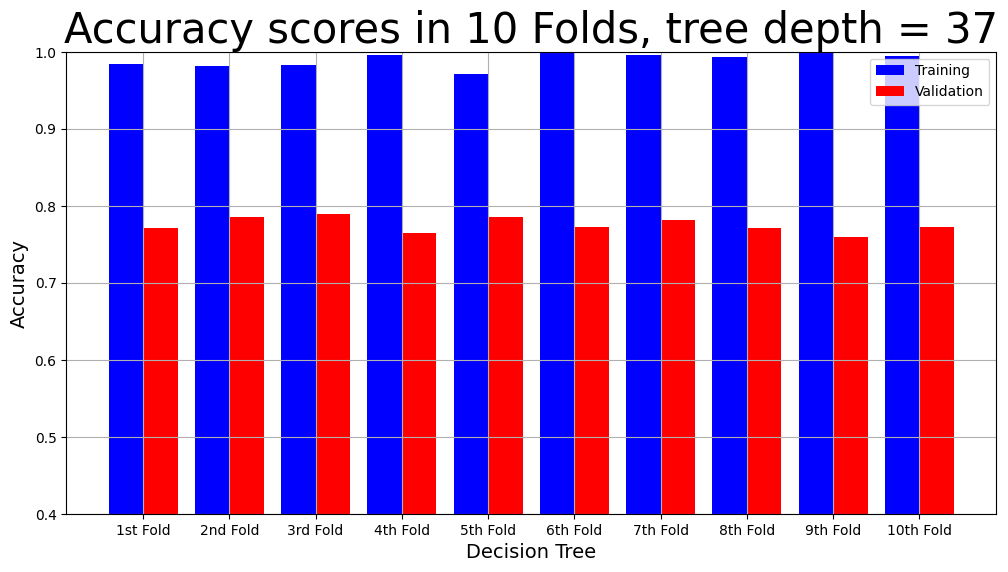

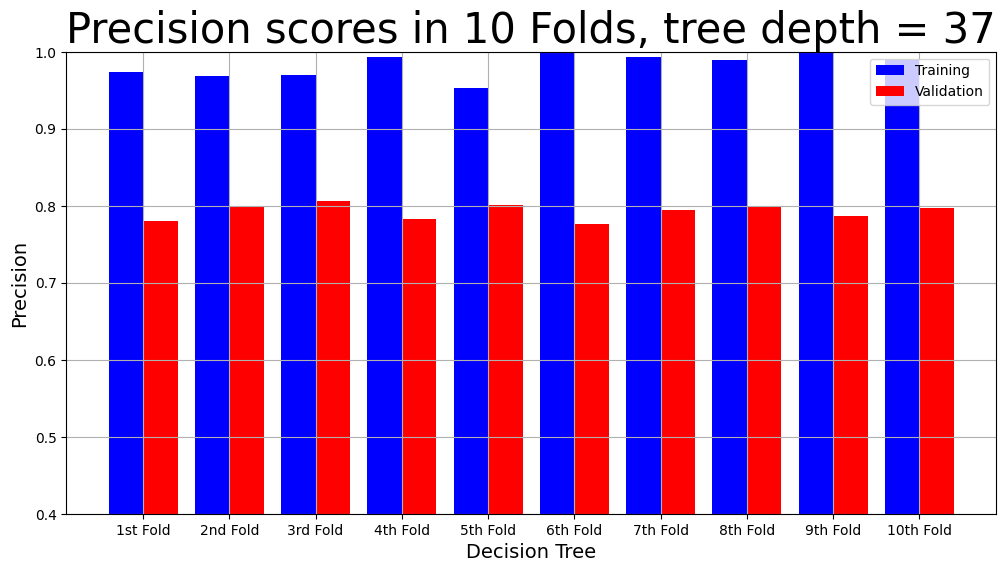

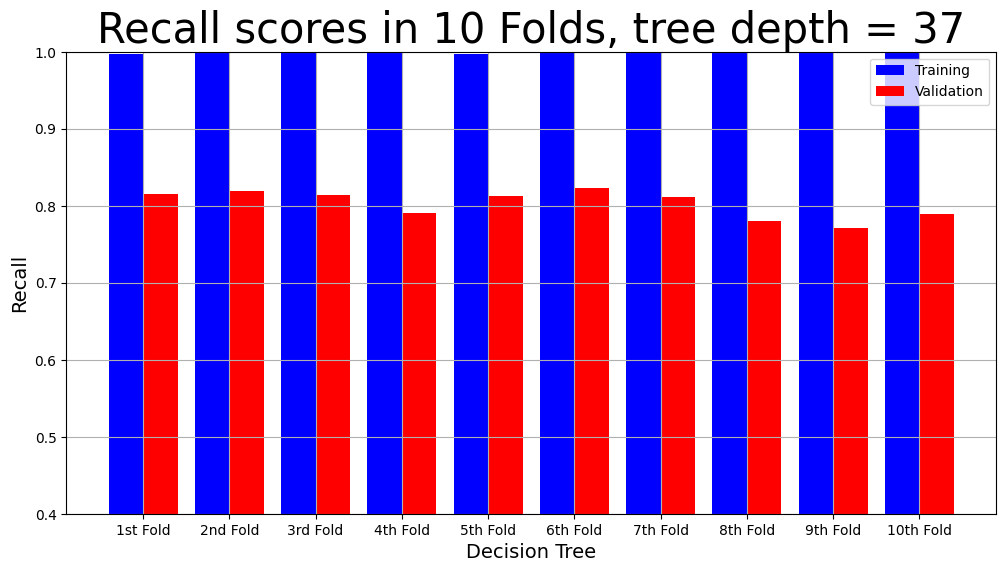

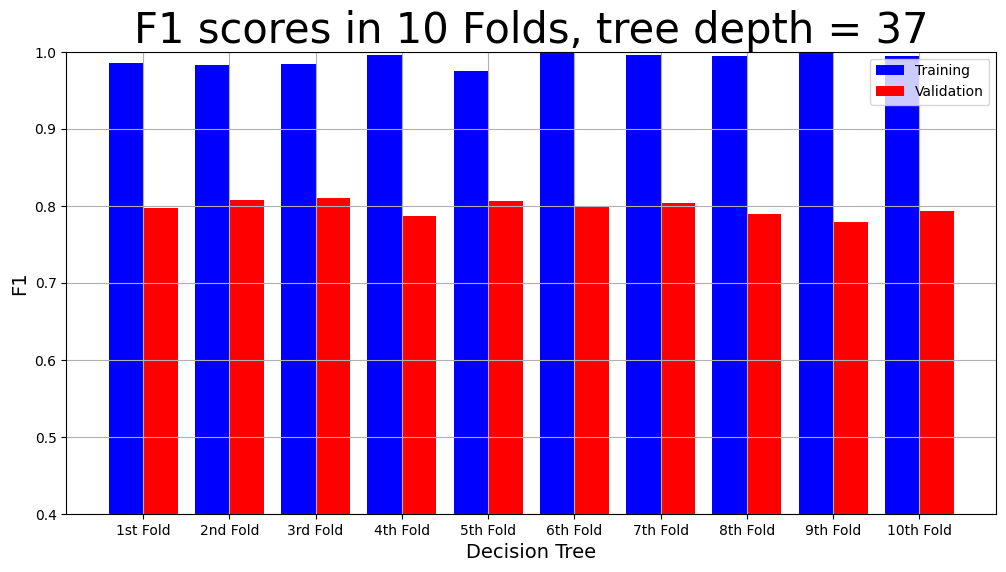

c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



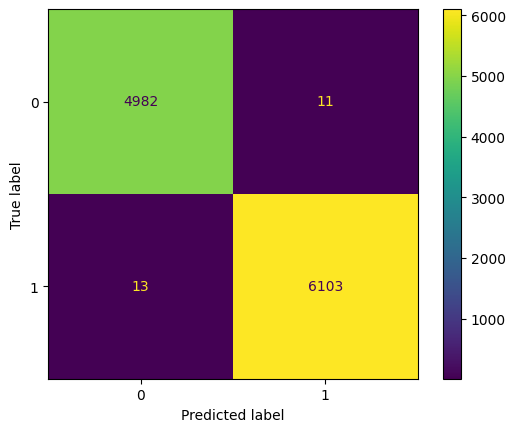

c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names



In [25]:

fold_classify_and_plot1(df, label, cv=10, max_tree_depth=max_depth, criterion="gini")

Maximum tree depth of 10 for more interpretability

{'Training Accuracy scores': array([0.86257251, 0.86007201, 0.86397279, 0.86317263, 0.85957191,
       0.86687337, 0.86557311, 0.86277255, 0.86547309, 0.86428643]), 'Mean Training Accuracy': 86.34340439445026, 'Training Precision scores': array([0.80412371, 0.80152784, 0.80587541, 0.80393886, 0.79997073,
       0.80906532, 0.80936803, 0.80537905, 0.81353633, 0.80725926]), 'Mean Training Precision': 0.8060044536379607, 'Training Recall scores': array([0.99200581, 0.99127907, 0.99182413, 0.99382267, 0.99327762,
       0.99236919, 0.98873751, 0.99000908, 0.98038147, 0.98982743]), 'Mean Training Recall': 0.9903533983376634, 'Training F1 scores': array([0.88823816, 0.88636179, 0.88923277, 0.88885278, 0.88620522,
       0.89139127, 0.8901063 , 0.88820078, 0.8892001 , 0.88926969]), 'Mean Training F1 Score': 0.8887058859451302, 'Validation Accuracy scores': array([0.83348335, 0.83438344, 0.84968497, 0.83888389, 0.84968497,
       0.81458146, 0.83978398, 0.84068407, 0.83348335, 0.83873874]), 'M

The following features were dropped:
[]


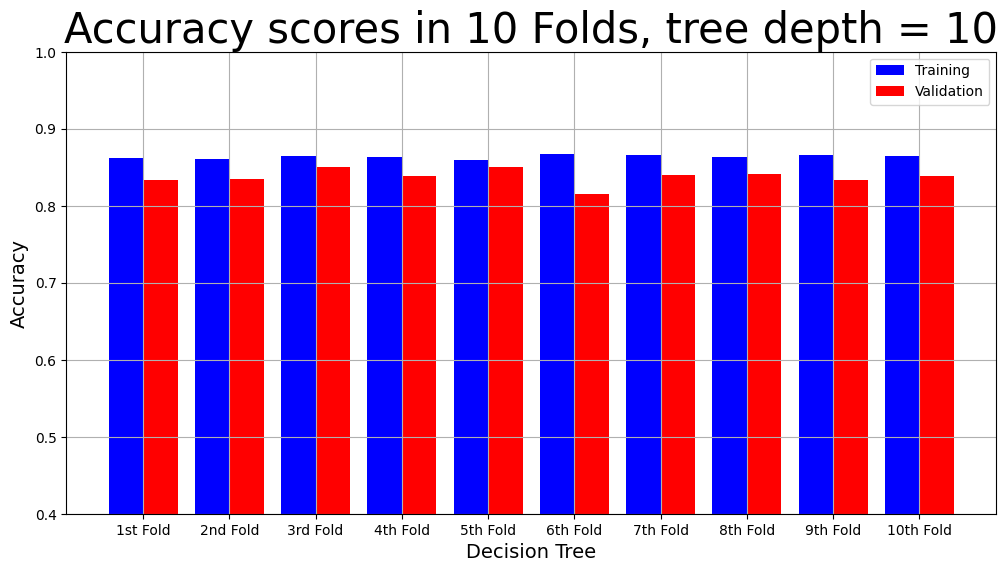

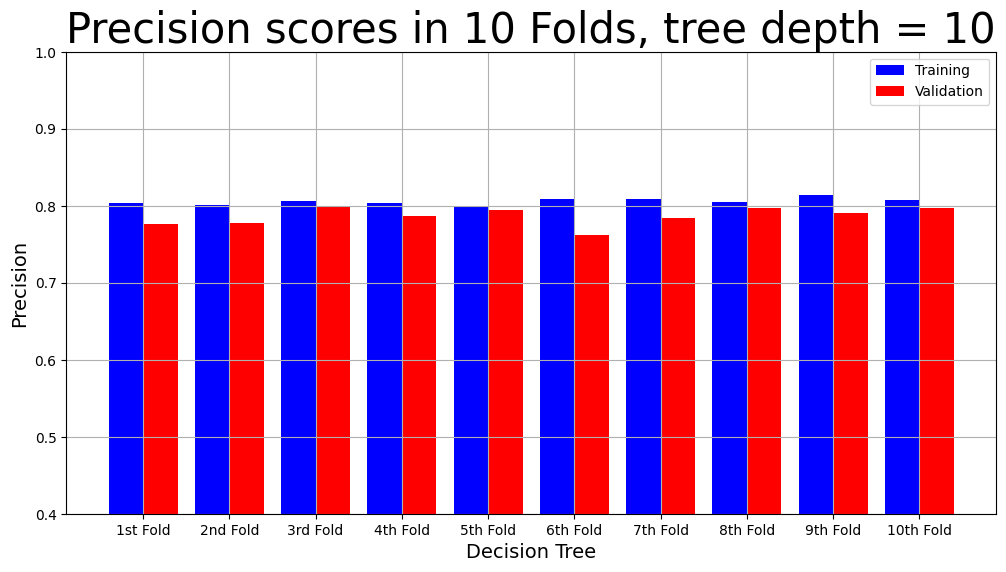

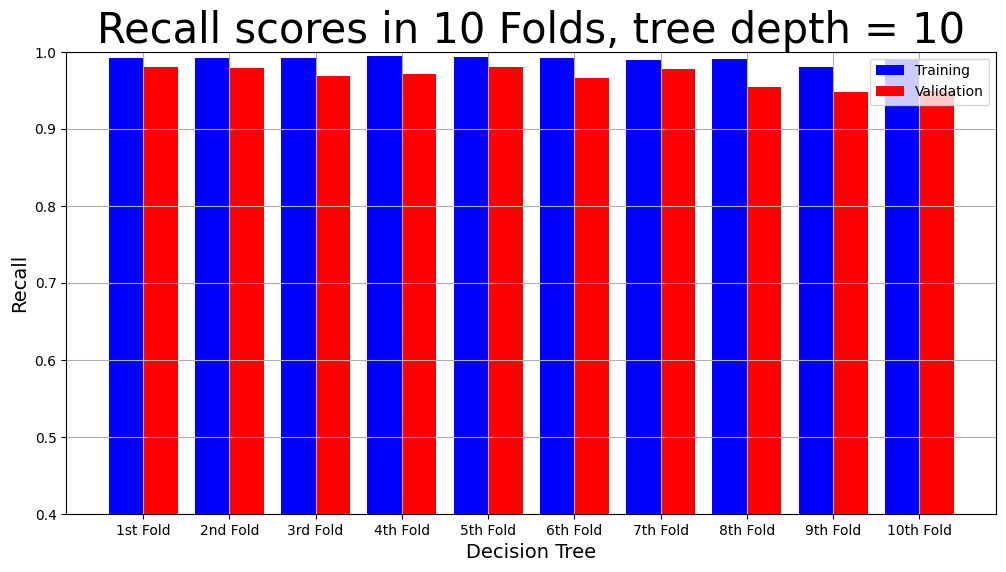

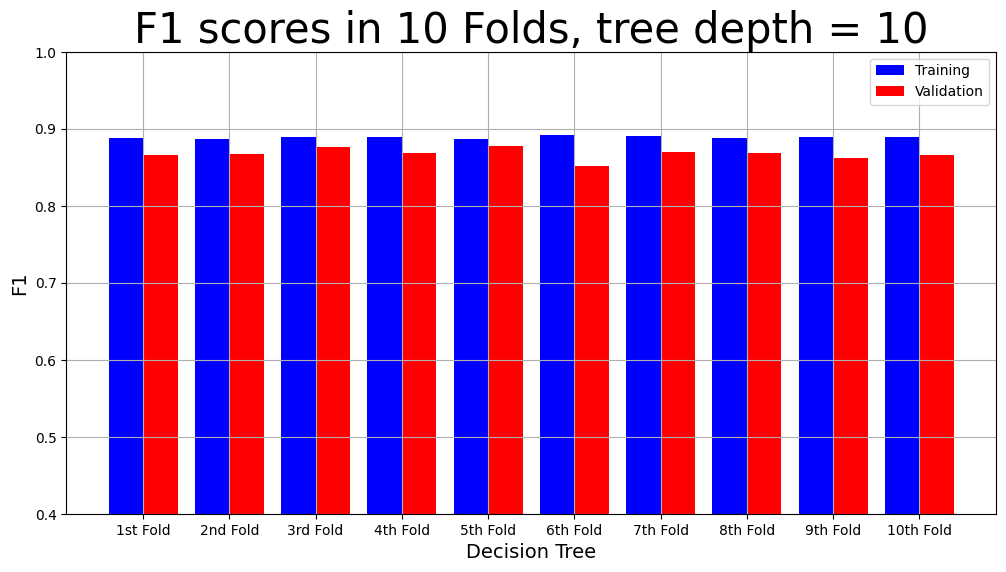

c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



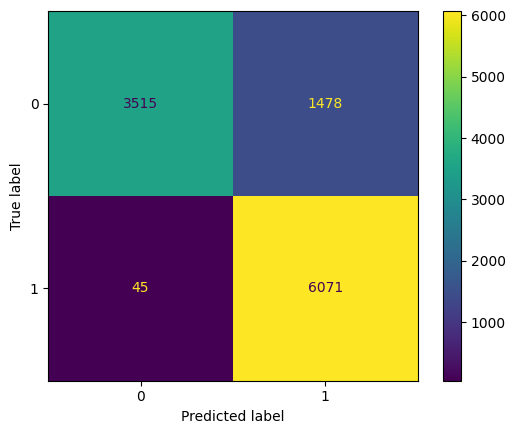

c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names



In [26]:
fold_classify_and_plot1(df, label, cv=10, max_tree_depth=10, criterion="gini")

Maximum tree depth of 5 for even greater interpretability

{'Training Accuracy scores': array([0.84426885, 0.84186837, 0.84286857, 0.84346869, 0.84216843,
       0.84606921, 0.84706941, 0.84416883, 0.84606921, 0.84468447]), 'Mean Training Accuracy': 84.4270407236763, 'Training Precision scores': array([0.78856558, 0.78497748, 0.78678722, 0.78950463, 0.78457524,
       0.79090242, 0.79141014, 0.78755646, 0.79059203, 0.78804665]), 'Mean Training Precision': 0.7882917857094177, 'Training Recall scores': array([0.97983285, 0.98164971, 0.98019622, 0.97583576, 0.98328488,
       0.97928779, 0.98074478, 0.9818347 , 0.98001817, 0.98201635]), 'Mean Training Recall': 0.9804701196586614, 'Training F1 scores': array([0.87385563, 0.87236619, 0.87290672, 0.8728366 , 0.87276246,
       0.87507103, 0.87596333, 0.87402975, 0.87517236, 0.87440356]), 'Mean Training F1 Score': 0.8739367626021206, 'Validation Accuracy scores': array([0.8289829 , 0.83078308, 0.84518452, 0.83168317, 0.84068407,
       0.80648065, 0.83618362, 0.83618362, 0.8379838 , 0.85135135]), 'Me

The following features were dropped:
['total_replies', 'total_likes', 'avg_text_length', 'account_discussion_creation_ratio', 'entropy_for_minute', 'entropy_for_day', 'max_number_of_tweets_in_a_day', 'avg_tweets_per_actual_day', 'mean_inactive_period_length_in_seconds', 'mode_inactive_period_length_in_seconds', 'mode_count', 'statuses_count']


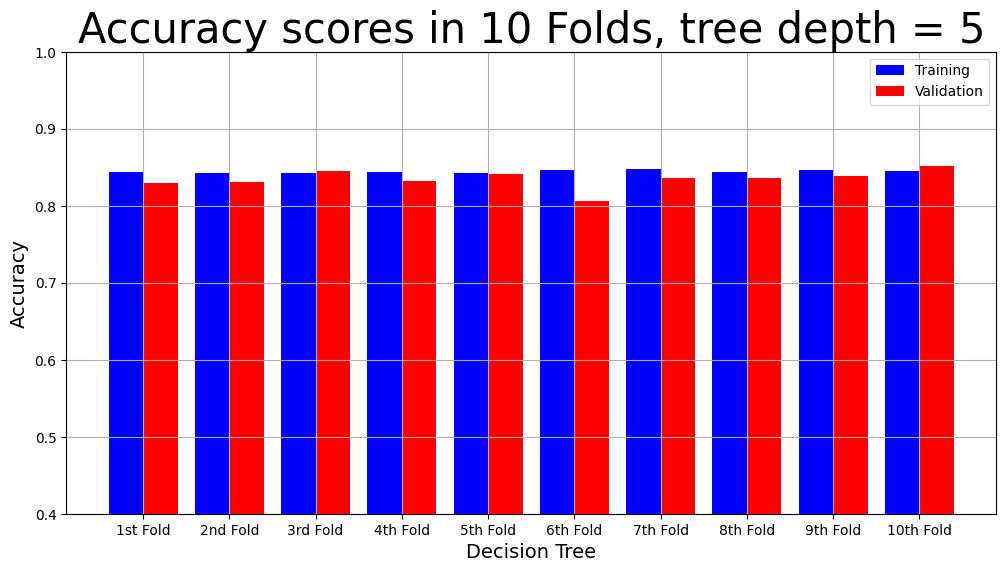

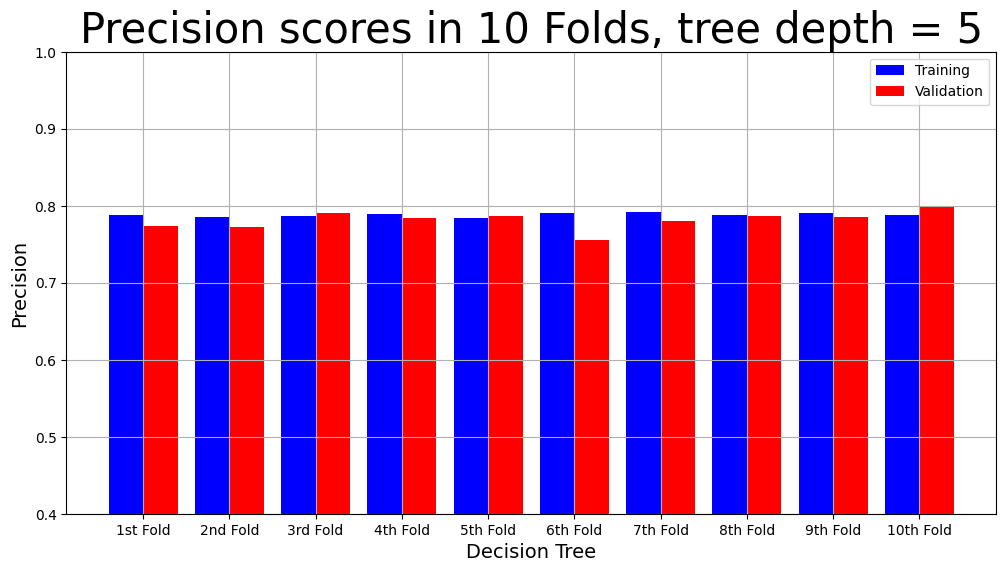

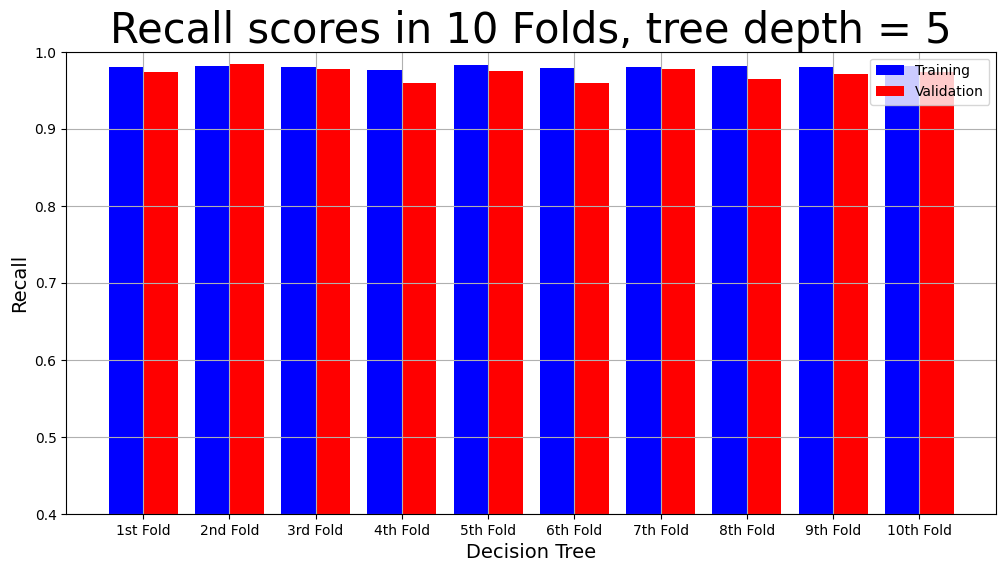

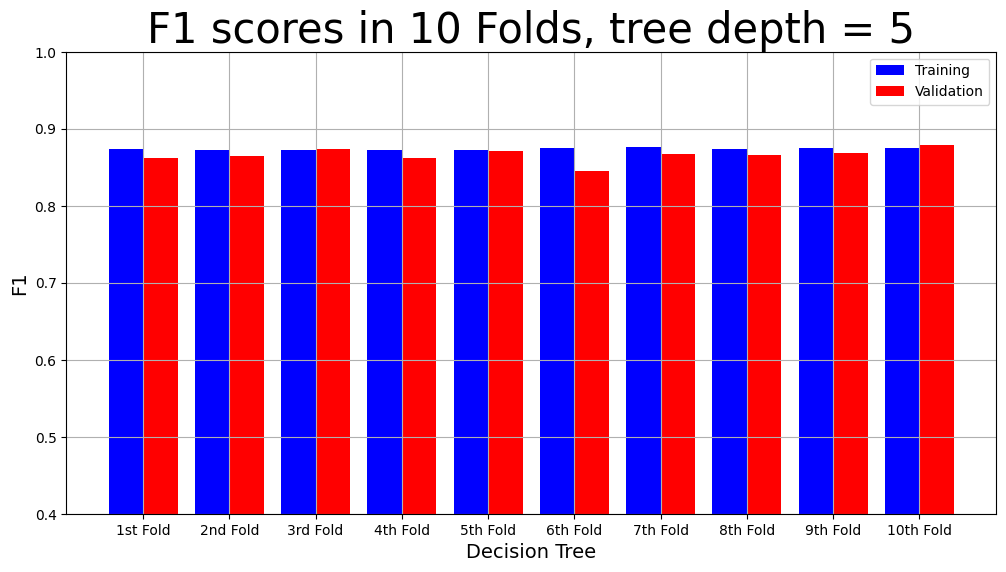

c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



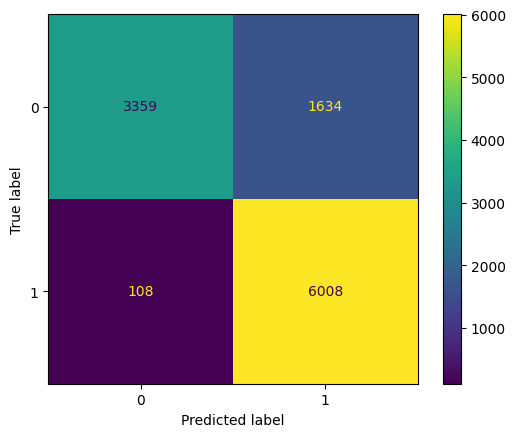

c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names



In [27]:
fold_classify_and_plot1(df, label, cv=10, max_tree_depth= 5, criterion='gini')

### Creating Different Decision tree models for SHAP explainability.

In [ ]:
import pickle
clf = DecisionTreeClassifier(max_depth=10)
X = df
y = label
clf = clf.fit(X, y)
tree_object = clf
filehandler = open("models/Dtree_10_depth_object", 'wb')
pickle.dump(tree_object, filehandler)

In [ ]:
clf = DecisionTreeClassifier(max_depth=len(df.columns))
X = df
y = label
clf = clf.fit(X, y)
tree_object = clf
filehandler = open("models/Dtree_28_depth_object", 'wb')
pickle.dump(tree_object, filehandler)

In [ ]:
clf = DecisionTreeClassifier(max_depth=max_depth)
X = df
y = label
clf = clf.fit(X, y)
tree_object = clf
filehandler = open("models/Dtree_37_depth_object", 'wb')
pickle.dump(tree_object, filehandler)